In [1]:
#import required libraries
import pandas as pd
import yfinance as yf
import numpy as np
import math
#import pandas_ta as ta
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import json
from pandas.io.json import json_normalize

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\akkrishn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [103]:
# parameter setup (default values in the original indicator)
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [224]:
value = input("Enter Stock Symbol:")
stock = yf.Ticker(value)
print(stock.info)
stock_df = stock.history(period="10y", interval='1d')
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock

Enter Stock Symbol: spy


{'exchange': 'PCX', 'shortName': 'SPDR S&P 500', 'longName': 'SPDR S&P 500 ETF Trust', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EDT', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-14400000', 'quoteType': 'ETF', 'symbol': 'SPY', 'messageBoardId': 'finmb_6160262', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': 1, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 727660800, 'annualReportExpenseRatio': None, 'totalAssets': 374031319040, 'bookValue': None, 'fundFamily': 'SPDR State Street Global Advisors', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': 0.012999999, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHint': 2, 'threeYear

Open        High         Low       Close     Volume  \
Date                                                                    
2011-09-30   94.235787   95.059167   93.099526   93.165398  288392300   
2011-10-03   92.621980   93.824113   90.415322   90.514130  365136800   
2011-10-04   89.213183   92.696082   88.455676   92.498466  459177500   
2011-10-05   92.729018   94.458114   91.872703   94.211098  284108000   
2011-10-06   94.161738   96.055514   93.461866   95.915535  257800800   
...                ...         ...         ...         ...        ...   
2021-09-23  439.850006  444.890015  439.600006  443.179993   76396000   
2021-09-24  441.440002  444.670013  441.209991  443.910004   62025800   
2021-09-27  442.809998  444.049988  441.899994  442.640015   61371100   
2021-09-28  439.690002  440.040009  432.940002  433.720001  130436300   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82142500   

            Dividends  Stock Splits  
Date                                 
2011-09-30        0.0             0  
2011-10-03        0.0             0  
2011-10-04        0.0             0  
2011-10-05        0.0             0  
2011-10-06        0.0             0  
...               ...           ...  
2021-09-23        0.0             0  
2021-09-24        0.0             0  
2021-09-27        0.0             0  
2021-09-28        0.0             0  
2021-09-29        0.0             0  

[2516 rows x 7 columns]

In [105]:
# calculate Bollinger Bands
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std

In [106]:
#Stacked Moving averages
m_avg_08 = df_stock['Close'].ewm(span=8).mean()
m_avg_21 = df_stock['Close'].ewm(span=21).mean()
m_avg_34 = df_stock['Close'].ewm(span=34).mean()
m_avg_55 = df_stock['Close'].ewm(span=55).mean()
m_avg_89 = df_stock['Close'].ewm(span=89).mean()

df_stock['m_avg_08'] = m_avg_08
df_stock['m_avg_21'] = m_avg_21
df_stock['m_avg_34'] = m_avg_34
df_stock['m_avg_55'] = m_avg_55
df_stock['m_avg_89'] = m_avg_89

In [107]:
# calculate Keltner Channel
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma = df_stock['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

In [108]:
#ADX Calculations

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean()

In [109]:
# check for 'squeeze'
df_stock['squeeze_on'] = (df_stock['lower_BB'] > df_stock['lower_KC']) & (df_stock['upper_BB'] < df_stock['upper_KC'])
df_stock['squeeze_off'] = (df_stock['lower_BB'] < df_stock['lower_KC']) & (df_stock['upper_BB'] > df_stock['upper_KC'])

In [110]:
# Momentum
highest = df_stock['High'].rolling(window = length_KC).max()
lowest = df_stock['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df_stock['value'] = (df_stock['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df_stock['value'] = df_stock['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y, x, 1)[1], raw=True)

df_stock[['squeeze_on', 'squeeze_off']] = (df_stock[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock["pct_change"] = df_stock['Close'].pct_change()*100

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions =  [
    (df_stock['pct_change'] > 0),
    (df_stock['pct_change'] < 0)
]

label = [1, 0]
df_stock['profitable?'] = np.select(conditions, label) 
df_stock.dropna(inplace=True)
df_stock.tail(100)

Open        High         Low       Close     Volume  \
Date                                                                    
2021-05-10  419.777439  420.015883  415.117659  415.246826   81852400   
2021-05-11  410.438030  412.594030  407.417611  411.540863  116888000   
2021-05-12  408.580081  409.931302  401.396659  402.797577  134811000   
2021-05-13  404.446863  409.692838  404.397167  407.636169  106394000   
2021-05-14  410.547290  414.799708  410.517484  413.895569   82201600   
2021-05-17  412.713270  413.706826  410.696322  412.842407   65129200   
2021-05-18  413.120604  413.378938  409.116574  409.285492   59810200   
2021-05-19  404.297850  408.401211  402.718069  408.212433  106467100   
2021-05-20  409.146387  413.945280  409.017250  412.603973   78022200   
2021-05-21  414.183730  415.505177  411.779342  412.266174   76578700   
2021-05-24  414.650678  417.611486  414.392344  416.468903   51376700   
2021-05-25  417.621389  417.998945  414.928861  415.544861   57451400   
2021-05-26  416.170814  416.906036  415.067981  416.369537   43088600   
2021-05-27  417.462438  418.008882  416.290019  416.588104   56707700   
2021-05-28  418.257313  418.535507  417.084924  417.333313   58520200   
2021-06-01  419.847005  419.996032  416.498726  416.965698   54216600   
2021-06-02  417.661180  418.515654  416.588153  417.621429   49097100   
2021-06-03  415.157418  417.283612  413.597527  416.071472   58138800   
2021-06-04  418.038716  420.194746  416.141020  419.876801   55938800   
2021-06-07  419.866868  420.055646  418.475896  419.469452   51555000   
2021-06-08  420.383507  420.482868  417.611507  419.558868   47134300   
2021-06-09  420.453031  420.532533  418.694448  418.932892   48436300   
2021-06-10  420.234444  421.893696  418.833526  420.880249   51020100   
2021-06-11  421.466499  421.694997  420.095386  421.575775   45570800   
2021-06-14  421.695015  422.628960  420.373599  422.519684   42358500   
2021-06-15  422.678635  422.718355  420.810745  421.744690   51508500   
2021-06-16  421.893704  422.132147  417.214063  419.389923   80386100   
2021-06-17  418.952800  420.294076  416.617937  419.250854   90949700   
2021-06-18  415.758054  416.495682  413.375703  413.595001  118676300   
2021-06-21  415.468959  419.715365  414.601742  419.515991   72822000   
2021-06-22  419.506057  422.645992  418.738497  421.758820   57700300   
2021-06-23  421.838570  422.695809  421.160749  421.250458   49445400   
2021-06-24  423.533141  424.191007  423.263984  423.742462   45110300   
2021-06-25  424.539896  425.726098  424.191007  425.247620   58129500   
2021-06-28  425.805859  426.284307  424.529948  426.104889   53159600   
2021-06-29  426.513585  427.191406  425.765980  426.334167   35970500   
2021-06-30  425.845732  427.410726  425.815829  426.693024   64827900   
2021-07-01  427.500435  429.224921  427.430651  429.055450   53441000   
2021-07-02  430.291489  432.713722  429.145137  432.334930   57697700   
2021-07-06  432.394746  432.624023  428.636797  431.547455   68710400   
2021-07-07  432.275138  433.371631  430.132010  433.072571   63549500   
2021-07-08  427.410704  430.351295  426.154718  429.543884   97595200   
2021-07-09  431.148739  434.448166  429.334544  434.129181   76238600   
2021-07-12  434.039479  435.953361  433.580957  435.684204   52889600   
2021-07-13  434.846893  436.441789  433.919870  434.198975   52911300   
2021-07-14  436.003193  436.521551  433.521154  434.846893   64130400   
2021-07-15  433.421470  434.139172  431.338148  433.361664   55126400   
2021-07-16  434.617624  434.667452  429.543883  429.962524   75874700   
2021-07-19  424.828990  430.032321  420.622465  423.612885  147987000   
2021-07-20  424.320617  431.039114  423.473325  429.683441   99608200   
2021-07-21  430.959358  433.311838  429.633619  433.162292   64724400   
2021-07-22  433.351665  434.328546  432.305030  434.069366   47878500   
2021-07-23  436.122810  438.893931  435.395161  438.535095   63766600   
202

In [111]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2 = df_stock['value'][-1] > 0

enter_long = long_cond1 and long_cond2
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df_stock['value'][-1] < 0
enter_short = short_cond1 and short_cond2

In [112]:
import mplfinance as mpf
%matplotlib widget

In [113]:
ohcl = df_stock[['Open', 'High', 'Close', 'Low']]
ohcl.head()

Open        High       Close         Low
Date                                                      
2011-11-28   98.426815   98.953777   98.566788   97.833980
2011-11-29   98.846764   99.628972   98.846764   98.484474
2011-11-30  101.679153  103.103603  102.914223   98.805560
2011-12-01  102.798958  103.449429  102.897766  102.453140
2011-12-02  103.844673  104.157555  102.807213  102.741341

In [114]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock['value'][ind-1]:
      color='red'
  colors.append(color)

In [115]:
len(colors)

2476

In [116]:
df_stock['colors'] = colors

In [117]:
df_stock.head()

Open        High         Low       Close     Volume  \
Date                                                                    
2011-11-28   98.426815   98.953777   97.833980   98.566788  210686000   
2011-11-29   98.846764   99.628972   98.484474   98.846764  199241500   
2011-11-30  101.679153  103.103603   98.805560  102.914223  324439500   
2011-12-01  102.798958  103.449429  102.453140  102.897766  176954800   
2011-12-02  103.844673  104.157555  102.741341  102.807213  221109700   

            Dividends  Stock Splits  Moving average    upper_BB   lower_BB  \
Date                                                                         
2011-11-28        0.0             0      100.276809  105.817035  94.736583   
2011-11-29        0.0             0      100.138548  105.709891  94.567205   
2011-11-30        0.0             0      100.406521  106.020537  94.792505   
2011-12-01        0.0             0      100.646721  106.296623  94.996818   
2011-12-02        0.0             0      100.854785  106.415128  95.294441   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-11-28   98.688487  100.326450  100.587356  100.577797  100.480544   
2011-11-29   98.723660  100.189431  100.478717  100.498832  100.421111   
2011-11-30   99.654915  100.441321  100.629932  100.607935  100.510538   
2011-12-01  100.375560  100.668056  100.770045  100.710398  100.595015   
2011-12-02  100.915934  100.865230  100.895325  100.803384  100.672280   

                 tr0       tr1       tr2        tr    upper_KC   lower_KC  \
Date                                                                        
2011-11-28  1.119797  3.161785  2.041988  3.161785  104.526671  96.026947   
2011-11-29  1.144498  1.062184  0.082313  1.144498  104.206834  96.070262   
2011-11-30  4.298043  4.256839  0.041204  4.298043  104.893373  95.919669   
2011-12-01  0.996289  0.535206  0.461082  0.996289  104.903346  96.390095   
2011-12-02  1.416214  1.259789  0.156425  1.416214  104.980137  96.729432   

                 atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                
2011-11-28  2.102467  23.835824  32.217715  18.739690         0.0   
2011-11-29  1.974423  26.042963  31.733250  18.427065         0.0   
2011-11-30  2.284900  32.189741  25.371424  17.794200         0.0   
2011-12-01  2.112768  33.438122  25.394147  17.359255         0.0   
2011-12-02  2.019745  34.984256  24.590617  17.104668         0.0   

            squeeze_off     value  pct_change  profitable?  colors  
Date                                                                
2011-11-28          1.0 -4.234372    2.896688            1  yellow  
2011-11-29          1.0 -3.934047    0.284047            1  yellow  
2011-11-30          1.0 -3.061661    4.114914            1  yellow  
2011-12-01          1.0 -2.464412   -0.015991            0  yellow  
2011-12-02          1.0 -1.847177   -0.088003            0  yellow

In [119]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock['Moving average'], color = 'black'),
        mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
        mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
        mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [120]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs = stochastics( df_stock, 'Low', 'High', 'Close', 14, 3 )
slow_k = stochs['k_slow'].values
fast_k = stochs['k_fast'].values
df_stock["slow_K"] = slow_k
df_stock['fast_K'] = fast_k
df_stock

Open        High         Low       Close     Volume  \
Date                                                                    
2011-11-28   98.426815   98.953777   97.833980   98.566788  210686000   
2011-11-29   98.846764   99.628972   98.484474   98.846764  199241500   
2011-11-30  101.679153  103.103603   98.805560  102.914223  324439500   
2011-12-01  102.798958  103.449429  102.453140  102.897766  176954800   
2011-12-02  103.844673  104.157555  102.741341  102.807213  221109700   
...                ...         ...         ...         ...        ...   
2021-09-23  439.850006  444.890015  439.600006  443.179993   76396000   
2021-09-24  441.440002  444.670013  441.209991  443.910004   62025800   
2021-09-27  442.809998  444.049988  441.899994  442.640015   61371100   
2021-09-28  439.690002  440.040009  432.940002  433.720001  130436300   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82142500   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2011-11-28        0.0             0      100.276809  105.817035   94.736583   
2011-11-29        0.0             0      100.138548  105.709891   94.567205   
2011-11-30        0.0             0      100.406521  106.020537   94.792505   
2011-12-01        0.0             0      100.646721  106.296623   94.996818   
2011-12-02        0.0             0      100.854785  106.415128   95.294441   
...               ...           ...             ...         ...         ...   
2021-09-23        0.0             0      442.883697  453.788387  431.979007   
2021-09-24        0.0             0      442.981441  453.905427  432.057455   
2021-09-27        0.0             0      442.948924  453.819313  432.078535   
2021-09-28        0.0             0      442.069979  453.719786  430.420172   
2021-09-29        0.0             0      441.344268  453.436795  429.251741   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-11-28   98.688487  100.326450  100.587356  100.577797  100.480544   
2011-11-29   98.723660  100.189431  100.478717  100.498832  100.421111   
2011-11-30   99.654915  100.441321  100.629932  100.607935  100.510538   
2011-12-01  100.375560  100.668056  100.770045  100.710398  100.595015   
2011-12-02  100.915934  100.865230  100.895325  100.803384  100.672280   
...                ...         ...         ...         ...         ...   
2021-09-23  440.740741  442.915933  442.243650  439.132384  432.417211   
2021-09-24  441.445022  443.006303  442.338870  439.303013  432.672606   
2021-09-27  441.710576  442.973004  442.356079  439.422192  432.894104   
2021-09-28  439.934893  442.131822  441.862589  439.218542  432.912458   
2021-09-29  438.716030  441.433476  441.439013  439.048238  432.946625   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2011-11-28  1.119797  3.161785  2.041988  3.161785  104.526671   96.026947   
2011-11-29  1.144498  1.062184  0.082313  1.144498  104.206834   96.070262   
2011-11-30  4.298043  4.256839  0.041204  4.298043  104.893373   95.919669   
2011-12-01  0.996289  0.535206  0.461082  0.996289  104.903346   96.390095   
2011-12-02  1.416214  1.259789  0.156425  1.416214  104.980137   96.729432   
...              ...       ...       ...       ...         ...         ...   
2021-09-23  5.290009  7.030029  1.740021  7.030029  452.839647  432.927747   
2021-09-24  3.460022  1.490021  1.970001  3.460022  452.661399  433.301482   
2021-09-27  2.149994  0.139984  2.010010  2.149994  452.139794  433.758054   
2021-09-28  7.100006  2.600006  9.700012  9.700012  452.188954  431.951004   
2021-09-29  3.190002  3.320007  0.130005  3.320007  451.146974  431.541562   

                 atr    plus_di   minus_di        adx  squeeze

In [121]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [122]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock['rsi_14'] = get_rsi(df_stock['Close'], 14)
df_stock = df_stock.dropna()
df_stock['Overbought'] = 70
df_stock['Oversold'] = 30
df_stock

Open        High         Low       Close     Volume  \
Date                                                                    
2011-12-19  101.139138  101.354577   99.457078   99.672516  183903000   
2011-12-20  101.238568  102.862627   99.738801  102.688622  225418100   
2011-12-21  102.688611  103.044910  101.710861  102.887474  194230900   
2011-12-22  103.268646  103.906672  102.937210  103.798950  119465400   
2011-12-23  104.130357  104.760096  103.914926  104.726952   92187200   
...                ...         ...         ...         ...        ...   
2021-09-23  439.850006  444.890015  439.600006  443.179993   76396000   
2021-09-24  441.440002  444.670013  441.209991  443.910004   62025800   
2021-09-27  442.809998  444.049988  441.899994  442.640015   61371100   
2021-09-28  439.690002  440.040009  432.940002  433.720001  130436300   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82142500   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2011-12-19        0.0             0      101.370123  106.584497   96.155750   
2011-12-20        0.0             0      101.496114  106.648520   96.343709   
2011-12-21        0.0             0      101.629025  106.647085   96.610965   
2011-12-22        0.0             0      101.836250  106.289039   97.383460   
2011-12-23        0.0             0      102.112235  105.792375   98.432095   
...               ...           ...             ...         ...         ...   
2021-09-23        0.0             0      442.883697  453.788387  431.979007   
2021-09-24        0.0             0      442.981441  453.905427  432.057455   
2021-09-27        0.0             0      442.948924  453.819313  432.078535   
2021-09-28        0.0             0      442.069979  453.719786  430.420172   
2021-09-29        0.0             0      441.344268  453.436795  429.251741   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-12-19  101.027714  101.374300  101.348178  101.224690  101.072127   
2011-12-20  101.396805  101.494308  101.427549  101.284498  101.121865   
2011-12-21  101.728065  101.621465  101.513816  101.349651  101.175731   
2011-12-22  102.188262  101.820136  101.648582  101.448715  101.255103   
2011-12-23  102.752415  102.085262  101.829797  101.580682  101.359315   
...                ...         ...         ...         ...         ...   
2021-09-23  440.740741  442.915933  442.243650  439.132384  432.417211   
2021-09-24  441.445022  443.006303  442.338870  439.303013  432.672606   
2021-09-27  441.710576  442.973004  442.356079  439.422192  432.894104   
2021-09-28  439.934893  442.131822  441.862589  439.218542  432.912458   
2021-09-29  438.716030  441.433476  441.439013  439.048238  432.946625   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2011-12-19  1.897499  0.604897  1.292602  1.897499  105.152036   97.588211   
2011-12-20  3.123826  3.190111  0.066285  3.190111  105.515274   97.476954   
2011-12-21  1.334049  0.356289  0.977760  1.334049  105.524871   97.733179   
2011-12-22  0.969463  1.019198  0.049736  1.019198  105.562624   98.109875   
2011-12-23  0.845171  0.961146  0.115975  0.961146  105.674062   98.550408   
...              ...       ...       ...       ...         ...         ...   
2021-09-23  5.290009  7.030029  1.740021  7.030029  452.839647  432.927747   
2021-09-24  3.460022  1.490021  1.970001  3.460022  452.661399  433.301482   
2021-09-27  2.149994  0.139984  2.010010  2.149994  452.139794  433.758054   
2021-09-28  7.100006  2.600006  9.700012  9.700012  452.188954  431.951004   
2021-09-29  3.190002  3.320007  0.130005  3.320007  451.146974  431.541562   

                 atr    plus_di   minus_di        adx  squeeze

In [123]:
apds2 = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock['Moving average'], color = 'black'),
         mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock['slow_K'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock['fast_K'], panel=2, color = 'blue'),
         mpf.make_addplot(df_stock['Overbought'], panel=2, color = 'green'),
         mpf.make_addplot(df_stock['Oversold'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock['rsi_14'], panel=3, color='purple')]
fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [124]:
for i in range(2,df_stock.shape[0]):
    current = df_stock.iloc[i,:]
    prev = df_stock.iloc[i-1,:]
    prev_2 = df_stock.iloc[i-2,:]
    realbody = abs(current['Open'] - current['Close'])
    candle_range = current['High'] - current['Low']
    idx = df_stock.index[i]  
# Bullish swing
    df_stock.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
# Bearish swing
    df_stock.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
# Bullish pinbar
    df_stock.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
# Bearish pinbar
    df_stock.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']
    
  # Inside bar
    df_stock.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']
    
  # Outside bar
    df_stock.loc[idx,'Outside bar'] = current['High'] > prev['High'] and current['Low'] < prev['Low']
  
  # Bullish engulfing
    df_stock.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
# Bearish engulfing
    df_stock.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']

df_stock.fillna(False, inplace=True)

In [125]:
df_stock

Open        High         Low       Close     Volume  \
Date                                                                    
2011-12-19  101.139138  101.354577   99.457078   99.672516  183903000   
2011-12-20  101.238568  102.862627   99.738801  102.688622  225418100   
2011-12-21  102.688611  103.044910  101.710861  102.887474  194230900   
2011-12-22  103.268646  103.906672  102.937210  103.798950  119465400   
2011-12-23  104.130357  104.760096  103.914926  104.726952   92187200   
...                ...         ...         ...         ...        ...   
2021-09-23  439.850006  444.890015  439.600006  443.179993   76396000   
2021-09-24  441.440002  444.670013  441.209991  443.910004   62025800   
2021-09-27  442.809998  444.049988  441.899994  442.640015   61371100   
2021-09-28  439.690002  440.040009  432.940002  433.720001  130436300   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82142500   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2011-12-19        0.0             0      101.370123  106.584497   96.155750   
2011-12-20        0.0             0      101.496114  106.648520   96.343709   
2011-12-21        0.0             0      101.629025  106.647085   96.610965   
2011-12-22        0.0             0      101.836250  106.289039   97.383460   
2011-12-23        0.0             0      102.112235  105.792375   98.432095   
...               ...           ...             ...         ...         ...   
2021-09-23        0.0             0      442.883697  453.788387  431.979007   
2021-09-24        0.0             0      442.981441  453.905427  432.057455   
2021-09-27        0.0             0      442.948924  453.819313  432.078535   
2021-09-28        0.0             0      442.069979  453.719786  430.420172   
2021-09-29        0.0             0      441.344268  453.436795  429.251741   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-12-19  101.027714  101.374300  101.348178  101.224690  101.072127   
2011-12-20  101.396805  101.494308  101.427549  101.284498  101.121865   
2011-12-21  101.728065  101.621465  101.513816  101.349651  101.175731   
2011-12-22  102.188262  101.820136  101.648582  101.448715  101.255103   
2011-12-23  102.752415  102.085262  101.829797  101.580682  101.359315   
...                ...         ...         ...         ...         ...   
2021-09-23  440.740741  442.915933  442.243650  439.132384  432.417211   
2021-09-24  441.445022  443.006303  442.338870  439.303013  432.672606   
2021-09-27  441.710576  442.973004  442.356079  439.422192  432.894104   
2021-09-28  439.934893  442.131822  441.862589  439.218542  432.912458   
2021-09-29  438.716030  441.433476  441.439013  439.048238  432.946625   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2011-12-19  1.897499  0.604897  1.292602  1.897499  105.152036   97.588211   
2011-12-20  3.123826  3.190111  0.066285  3.190111  105.515274   97.476954   
2011-12-21  1.334049  0.356289  0.977760  1.334049  105.524871   97.733179   
2011-12-22  0.969463  1.019198  0.049736  1.019198  105.562624   98.109875   
2011-12-23  0.845171  0.961146  0.115975  0.961146  105.674062   98.550408   
...              ...       ...       ...       ...         ...         ...   
2021-09-23  5.290009  7.030029  1.740021  7.030029  452.839647  432.927747   
2021-09-24  3.460022  1.490021  1.970001  3.460022  452.661399  433.301482   
2021-09-27  2.149994  0.139984  2.010010  2.149994  452.139794  433.758054   
2021-09-28  7.100006  2.600006  9.700012  9.700012  452.188954  431.951004   
2021-09-29  3.190002  3.320007  0.130005  3.320007  451.146974  431.541562   

                 atr    plus_di   minus_di        adx  squeeze

In [126]:
columns = ['Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing','Bearish engulfing']


def convert(df):
    patterns = []
    for i in columns:
        if df[i]:
            patterns.append(i)
    #df['patterns'] = patterns
    if not patterns:
        patterns.append('No pattern')
    return patterns

In [127]:
#df_stock_dow.apply(convert, axis=1)
df_stock['pattern'] = df_stock.apply(convert, axis = 1)

In [128]:
df_stock['pattern'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[No pattern]                                  967
[Bullish swing]                               387
[Bearish swing]                               322
[Outside bar]                                 144
[Bearish swing, Inside bar]                   113
[Bullish swing, Inside bar]                    92
[Bearish pinbar]                               91
[Bearish swing, Bullish pinbar]                89
[Bullish pinbar]                               78
[Bullish swing, Bearish swing, Inside bar]     52
[Bullish pinbar, Outside bar]                  33
[Bullish swing, Bearish pinbar]                30
[Outside bar, Bearish engulfing]               23
[Outside bar, Bullish engulfing]               15
[Inside bar]                                   13
[Bearish pinbar, Outside bar]                  12
Name: pattern, dtype: int64

In [129]:
df_stock.tail()

Open        High         Low       Close     Volume  \
Date                                                                    
2021-09-23  439.850006  444.890015  439.600006  443.179993   76396000   
2021-09-24  441.440002  444.670013  441.209991  443.910004   62025800   
2021-09-27  442.809998  444.049988  441.899994  442.640015   61371100   
2021-09-28  439.690002  440.040009  432.940002  433.720001  130436300   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82142500   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2021-09-23        0.0             0      442.883697  453.788387  431.979007   
2021-09-24        0.0             0      442.981441  453.905427  432.057455   
2021-09-27        0.0             0      442.948924  453.819313  432.078535   
2021-09-28        0.0             0      442.069979  453.719786  430.420172   
2021-09-29        0.0             0      441.344268  453.436795  429.251741   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2021-09-23  440.740741  442.915933  442.243650  439.132384  432.417211   
2021-09-24  441.445022  443.006303  442.338870  439.303013  432.672606   
2021-09-27  441.710576  442.973004  442.356079  439.422192  432.894104   
2021-09-28  439.934893  442.131822  441.862589  439.218542  432.912458   
2021-09-29  438.716030  441.433476  441.439013  439.048238  432.946625   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2021-09-23  5.290009  7.030029  1.740021  7.030029  452.839647  432.927747   
2021-09-24  3.460022  1.490021  1.970001  3.460022  452.661399  433.301482   
2021-09-27  2.149994  0.139984  2.010010  2.149994  452.139794  433.758054   
2021-09-28  7.100006  2.600006  9.700012  9.700012  452.188954  431.951004   
2021-09-29  3.190002  3.320007  0.130005  3.320007  451.146974  431.541562   

                 atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                
2021-09-23  5.519391  17.332404  23.259687  20.497732         0.0   
2021-09-24  5.244809  16.936968  22.729020  20.076613         0.0   
2021-09-27  4.832167  17.070204  22.907820  19.685574         0.0   
2021-09-28  5.481213  13.973953  30.428959  19.437039         0.0   
2021-09-29  5.193052  13.695837  29.823348  20.695707         0.0   

            squeeze_off     value  pct_change  profitable?  colors     slow_K  \
Date                                                                            
2021-09-23          1.0 -4.553976    1.215002            1  yellow  39.802093   
2021-09-24          1.0 -4.128095    0.164721            1  yellow  55.396885   
2021-09-27          1.0 -4.139322   -0.286092            0     red  63.390530   
2021-09-28          1.0 -5.304931   -2.015185            0     red  50.198993   
2021-09-29          1.0 -5.998100    0.168314            1     red  36.700868   

               fast_K     rsi_14  Overbought  Oversold  Bullish swing  \
Date                                                                    
2021-09-23  61.402878  50.538170          70        30          False   
2021-09-24  66.877112  51.576119          70        30          False   
2021-09-27  61.891601  49.625096          70        30          False   
2021-09-28  21.828267  38.584806          70        30          False   
2021-09-29  26.382737  39.765862          70        30           True   

            Bearish swing  Bullish pinbar  Bearish pinbar  Inside bar  \
Date                                                                    
2021-09-23          False           False           False       False   
2021-09-24           True           False           False        True   
2021-09-27          False     

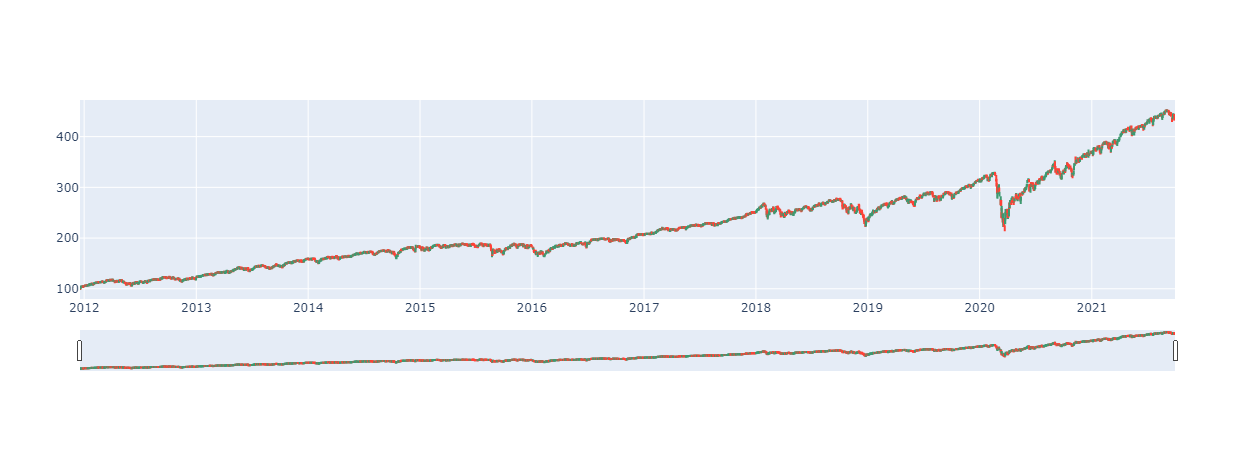

In [130]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df_stock.index,
                open=df_stock['Open'],
                high=df_stock['High'],
                low=df_stock['Low'],
                close=df_stock['Close'])])
fig.update_traces(text=df_stock['pattern'], selector=dict(type='candlestick'))
fig.show()

In [131]:
pattern_dict = {
    'Bullish swing': 'upswing pattern',
    'Bearish swing': 'downward pattern',
    'Bullish pinbar': 'upswing hammer',
    'Bearish pinbar': 'downswing hammer',
    'Inside bar': 'trend change',
    'Outside bar': 'trend change',
    'Bullish engulfing': 'upswing from downtrend',
    'Bearish engulfing': 'downswing from uptrend',
    'No pattern': 'No pattern detected'
    }

In [132]:
today = df_stock['pattern'][-1]
for i in today:
    print(f'Todays pattern is {i}, {pattern_dict[i]}')

Todays pattern is Bullish swing, upswing pattern
Todays pattern is Inside bar, trend change


In [133]:
import datetime
today_date = datetime.date.today()
today_date = str(today_date)
today_date
#& df_stock['squeeze_on'] == df_stock['squeeze_threshold']
#df_stock["value"] > df_stock['value_threshold']

'2021-09-29'

In [134]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker(index):
    if (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index] > df_stock['m_avg_34'][index] > df_stock['m_avg_55'][index] > df_stock['m_avg_89'][index]):
        print('Positive momentum')
    elif (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index] < df_stock['m_avg_34'][index] < df_stock['m_avg_55'][index] < df_stock['m_avg_89'][index]):
        print('Negative momentum')
    else:
        print('neutral')

In [135]:
df_stock['ADX_trend'] = 20

def ADX_trend_flag(index):
    if (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] > df_stock['minus_di'][index]):
        print('positive trend')
    elif (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] < df_stock['minus_di'][index]):
        print('negative trend')
    elif (df_stock['adx'][index] < df_stock['ADX_trend'][index]):
        print('neutral or sideways trend')

In [136]:
momentum_checker(-1)

neutral


In [137]:
df_stock.shape

(2461, 46)

In [138]:
ADX_trend_flag(-1)

negative trend


In [139]:
def warning(index):
    if (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index]):
        print('Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.')
    if (df_stock['m_avg_08'][index] < df_stock['m_avg_34'][index]):
        print('8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema')
    elif (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index]):
        print('Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger')

In [140]:
warning(-1)

Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.
8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema


In [141]:
def squeeze_momentum(index):
    if (df_stock['squeeze_on'][index] == 1.0):
        print('squeeze is on')
    else:
        print('squeeze is off')
    
    if (df_stock['colors'][index] == 'cyan'):
        print('stock is in a mark up mode')
    elif (df_stock['colors'][index] == 'blue'):
        print('stock is in a distribution mode')
    elif (df_stock['colors'][index] == 'yellow'):
        print('stock is in an accumulation mode')
    elif (df_stock['colors'][index] == 'red'):
        print('stock is in a mark down mode')

In [142]:
squeeze_momentum(-1)

squeeze is off
stock is in a mark down mode


In [143]:
df = yf.download(value,'2021-03-04', '2021-09-30')

[*********************100%***********************]  1 of 1 completed


In [144]:
fig, ax = plt.subplots()
ax.plot(df.Close, color='black')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [145]:
# Define minimum and maximum price points
price_min = df.Close.min()
price_max = df.Close.max()

In [146]:
# Fibonacci Levels considering original trend as upward move
diff = price_max - price_min
level1 = price_max - 0.236 * diff
level2 = price_max - 0.382 * diff
level3 = price_max - 0.500 * diff
level4 = price_max - 0.618 * diff

In [147]:
ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
ax.axhspan(level4, level3, alpha=0.5, color='red')
ax.axhspan(price_max, level4, alpha=0.5, color='powderblue')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

No handles with labels found to put in legend.


In [148]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
df_stock['value_threshold'] = abs(df_stock['value'].min()*.05)
df_stock['squeeze_threshold'] = 1.0
df_stock["squeeze_entry"] = np.logical_and(np.greater(df_stock["value"], df_stock['value_threshold']), 
                                           np.equal(df_stock['squeeze_on'], df_stock['squeeze_threshold']))
df_stock['squeeze_entry'] = df_stock['squeeze_entry'].astype(float)
df_stock['Entry/Exit'] = df_stock['squeeze_entry'].diff()
df_stock_clean = df_stock.dropna()


In [149]:
df_stock.shape

(2461, 50)

In [177]:
len(colors)

2476

In [178]:
def implement_bb_strategy(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*1.15):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal


In [179]:
buy_price, sell_price, squeeze_signal = implement_bb_strategy(df_stock["Close"], df_stock['squeeze_on'], df_stock['value'], 
                                                              df_stock['upper_KC'], df_stock['value_threshold'], df_stock['colors'])

In [180]:
df_stock['buy_price'] =  buy_price
df_stock['sell_price'] = sell_price
df_stock['squeeze_signal'] = squeeze_signal

In [181]:
df_stock['squeeze_on'][20]

0.0

In [182]:
# #from math import isclose

# #def discretionary(row):
#     #for row in df_stock.values:
#         i#f row[32] == 1:
#             temp_close = row[3]
#             val = 1
#         elif row[32] == 0:
#             try:
#                 if np.logical_and(np.greater((row[19]-temp_close), row[35]), row[32]):
#                     val = -1
#                 else:
#                     val = 0
#             except:
#                 val = 0
#     return val

# df_stock['discretionary_exit'] = df_stock.apply(discretionary, axis = 1)

In [183]:
df_stock

Open        High         Low       Close     Volume  \
Date                                                                    
2011-12-19  101.139138  101.354577   99.457078   99.672516  183903000   
2011-12-20  101.238568  102.862627   99.738801  102.688622  225418100   
2011-12-21  102.688611  103.044910  101.710861  102.887474  194230900   
2011-12-22  103.268646  103.906672  102.937210  103.798950  119465400   
2011-12-23  104.130357  104.760096  103.914926  104.726952   92187200   
...                ...         ...         ...         ...        ...   
2021-09-23  439.850006  444.890015  439.600006  443.179993   76396000   
2021-09-24  441.440002  444.670013  441.209991  443.910004   62025800   
2021-09-27  442.809998  444.049988  441.899994  442.640015   61371100   
2021-09-28  439.690002  440.040009  432.940002  433.720001  130436300   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82142500   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2011-12-19        0.0             0      101.370123  106.584497   96.155750   
2011-12-20        0.0             0      101.496114  106.648520   96.343709   
2011-12-21        0.0             0      101.629025  106.647085   96.610965   
2011-12-22        0.0             0      101.836250  106.289039   97.383460   
2011-12-23        0.0             0      102.112235  105.792375   98.432095   
...               ...           ...             ...         ...         ...   
2021-09-23        0.0             0      442.883697  453.788387  431.979007   
2021-09-24        0.0             0      442.981441  453.905427  432.057455   
2021-09-27        0.0             0      442.948924  453.819313  432.078535   
2021-09-28        0.0             0      442.069979  453.719786  430.420172   
2021-09-29        0.0             0      441.344268  453.436795  429.251741   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-12-19  101.027714  101.374300  101.348178  101.224690  101.072127   
2011-12-20  101.396805  101.494308  101.427549  101.284498  101.121865   
2011-12-21  101.728065  101.621465  101.513816  101.349651  101.175731   
2011-12-22  102.188262  101.820136  101.648582  101.448715  101.255103   
2011-12-23  102.752415  102.085262  101.829797  101.580682  101.359315   
...                ...         ...         ...         ...         ...   
2021-09-23  440.740741  442.915933  442.243650  439.132384  432.417211   
2021-09-24  441.445022  443.006303  442.338870  439.303013  432.672606   
2021-09-27  441.710576  442.973004  442.356079  439.422192  432.894104   
2021-09-28  439.934893  442.131822  441.862589  439.218542  432.912458   
2021-09-29  438.716030  441.433476  441.439013  439.048238  432.946625   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2011-12-19  1.897499  0.604897  1.292602  1.897499  105.152036   97.588211   
2011-12-20  3.123826  3.190111  0.066285  3.190111  105.515274   97.476954   
2011-12-21  1.334049  0.356289  0.977760  1.334049  105.524871   97.733179   
2011-12-22  0.969463  1.019198  0.049736  1.019198  105.562624   98.109875   
2011-12-23  0.845171  0.961146  0.115975  0.961146  105.674062   98.550408   
...              ...       ...       ...       ...         ...         ...   
2021-09-23  5.290009  7.030029  1.740021  7.030029  452.839647  432.927747   
2021-09-24  3.460022  1.490021  1.970001  3.460022  452.661399  433.301482   
2021-09-27  2.149994  0.139984  2.010010  2.149994  452.139794  433.758054   
2021-09-28  7.100006  2.600006  9.700012  9.700012  452.188954  431.951004   
2021-09-29  3.190002  3.320007  0.130005  3.320007  451.146974  431.541562   

                 atr    plus_di   minus_di        adx  squeeze

In [184]:
# Visualize exit position relative to close price
exit = df_stock[df_stock['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock[df_stock['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [185]:
position = []
for i in range(len(squeeze_signal)):
    if df_stock['squeeze_signal'][i] < 1:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock['Close'])):
    if df_stock['squeeze_signal'][i] == 1:
        position[i] = 1
    elif df_stock['squeeze_signal'][i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock['Close']
squeeze_signal = pd.DataFrame(squeeze_signal).rename(columns = {0:'squeeze_signal'}).set_index(df_stock.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock.index)

frames = [close_price, squeeze_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date       Close  squeeze_signal  squeeze_position
0    2011-12-19   99.672516             0.0                 0
1    2011-12-20  102.688622             0.0                 0
2    2011-12-21  102.887474             0.0                 0
3    2011-12-22  103.798950             0.0                 0
4    2011-12-23  104.726952             0.0                 0
...         ...         ...             ...               ...
2456 2021-09-23  443.179993             0.0                 0
2457 2021-09-24  443.910004             0.0                 0
2458 2021-09-27  442.640015             0.0                 0
2459 2021-09-28  433.720001             0.0                 0
2460 2021-09-29  434.450012             0.0                 0

[2461 rows x 4 columns]

In [186]:
stock_ret = pd.DataFrame(np.diff(df_stock['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)


Profit gained from the Squeeze strategy by investing $100k in spy is 263375.17
Profit percentage of the Squeeze strategy : 263%
263375.1735458374


In [187]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go

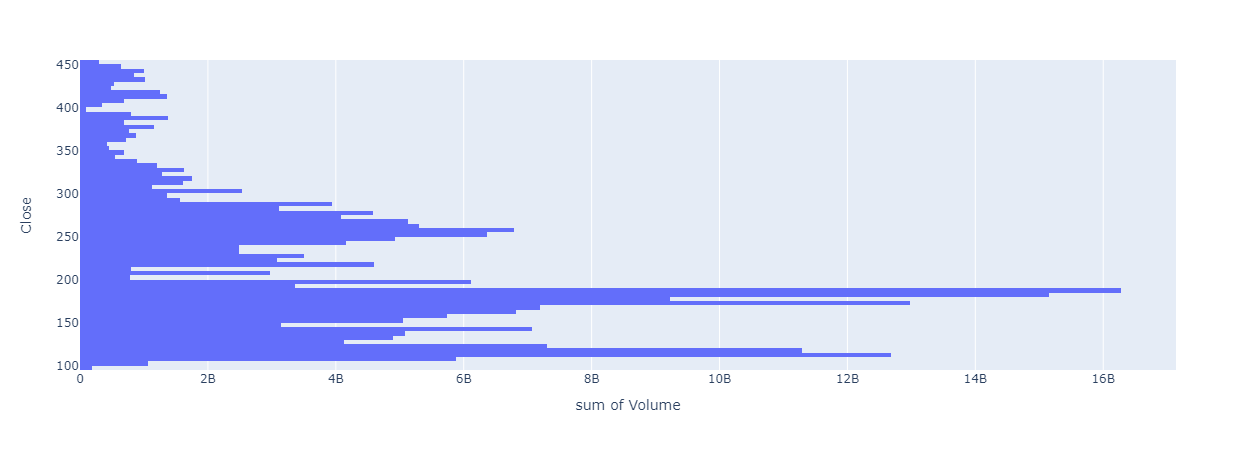

In [188]:
px.histogram(df_stock, x='Volume', y='Close', nbins=150, orientation='h').show()

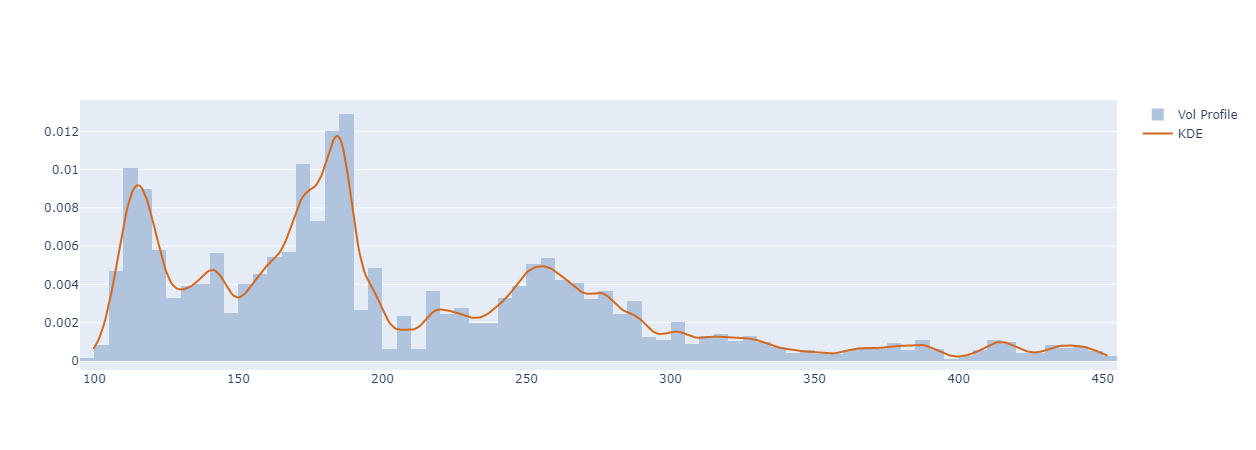

In [189]:
kde_factor = 0.05
num_samples = 500
close = df_stock['Close']
volume = df_stock['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

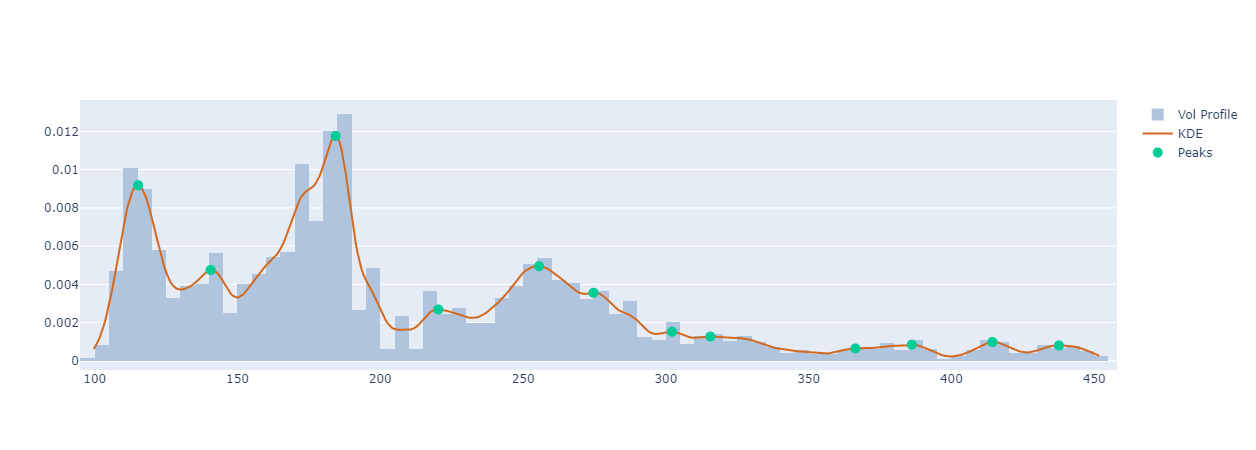

In [190]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [191]:
df_stock.to_csv('spy.csv')

In [192]:
# Set x variable list of features
x_var_list = ['Open', 'High', 'Low', 'Close', 'Moving average', 'upper_BB', 'lower_BB', 'm_avg_08', 'pct_change', 'squeeze_on', 'upper_KC', 'lower_KC', 'squeeze_signal']

# Filter by x-variable list
df_stock[x_var_list]

Open        High         Low       Close  Moving average  \
Date                                                                         
2011-12-19  101.139138  101.354577   99.457078   99.672516      101.370123   
2011-12-20  101.238568  102.862627   99.738801  102.688622      101.496114   
2011-12-21  102.688611  103.044910  101.710861  102.887474      101.629025   
2011-12-22  103.268646  103.906672  102.937210  103.798950      101.836250   
2011-12-23  104.130357  104.760096  103.914926  104.726952      102.112235   
...                ...         ...         ...         ...             ...   
2021-09-23  439.850006  444.890015  439.600006  443.179993      442.883697   
2021-09-24  441.440002  444.670013  441.209991  443.910004      442.981441   
2021-09-27  442.809998  444.049988  441.899994  442.640015      442.948924   
2021-09-28  439.690002  440.040009  432.940002  433.720001      442.069979   
2021-09-29  435.190002  437.040009  433.850006  434.450012      441.344268   

              upper_BB    lower_BB    m_avg_08  pct_change  squeeze_on  \
Date                                                                     
2011-12-19  106.584497   96.155750  101.027714   -1.069149         0.0   
2011-12-20  106.648520   96.343709  101.396805    3.026015         0.0   
2011-12-21  106.647085   96.610965  101.728065    0.193646         0.0   
2011-12-22  106.289039   97.383460  102.188262    0.885896         0.0   
2011-12-23  105.792375   98.432095  102.752415    0.894037         0.0   
...                ...         ...         ...         ...         ...   
2021-09-23  453.788387  431.979007  440.740741    1.215002         0.0   
2021-09-24  453.905427  432.057455  441.445022    0.164721         0.0   
2021-09-27  453.819313  432.078535  441.710576   -0.286092         0.0   
2021-09-28  453.719786  430.420172  439.934893   -2.015185         0.0   
2021-09-29  453.436795  429.251741  438.716030    0.168314         0.0   

              upper_KC    lower_KC  squeeze_signal  
Date                                                
2011-12-19  105.152036   97.588211             0.0  
2011-12-20  105.515274   97.476954             0.0  
2011-12-21  105.524871   97.733179             0.0  
2011-12-22  105.562624   98.109875             0.0  
2011-12-23  105.674062   98.550408             0.0  
...                ...         ...             ...  
2021-09-23  452.839647  432.927747             0.0  
2021-09-24  452.661399  433.301482             0.0  
2021-09-27  452.139794  433.758054             0.0  
2021-09-28  452.188954  431.951004             0.0  
2021-09-29  451.146974  431.541562             0.0  

[2461 rows x 13 columns]

In [204]:
# Shift DataFrame values by 1
df_stock[x_var_list] = df_stock[x_var_list].shift(1)
df_stock[x_var_list].tail()

Open        High         Low       Close  Moving average  \
Date                                                                         
2021-09-23  436.529999  437.910004  433.070007  433.630005      443.378037   
2021-09-24  436.049988  440.029999  433.750000  437.859985      442.852508   
2021-09-27  439.850006  444.890015  439.600006  443.179993      442.883697   
2021-09-28  441.440002  444.670013  441.209991  443.910004      442.981441   
2021-09-29  442.809998  444.049988  441.899994  442.640015      442.948924   

              upper_BB    lower_BB    m_avg_08  pct_change  squeeze_on  \
Date                                                                     
2021-09-23  453.619766  433.136309  440.667763   -0.094462         0.0   
2021-09-24  453.735914  431.969103  440.043812    0.975481         0.0   
2021-09-27  453.788387  431.979007  440.740741    1.215002         0.0   
2021-09-28  453.905427  432.057455  441.445022    0.164721         0.0   
2021-09-29  453.819313  432.078535  441.710576   -0.286092         0.0   

              upper_KC    lower_KC  squeeze_signal  
Date                                                
2021-09-23  452.598131  434.157943             0.0  
2021-09-24  452.398047  433.306969             0.0  
2021-09-27  452.839647  432.927747             0.0  
2021-09-28  452.661399  433.301482             0.0  
2021-09-29  452.139794  433.758054             0.0

In [205]:
# Drop NAs
df_stock = df_stock.dropna(subset=x_var_list)
df_stock = df_stock.dropna(subset=["pct_change"])

# Replace positive/negative infinity values
df_stock = df_stock.replace([np.inf, -np.inf], np.nan)

# Display sample data
df_stock.head()

Open        High         Low       Close     Volume  \
Date                                                                    
2011-12-21  101.139138  101.354577   99.457078   99.672516  194230900   
2011-12-22  101.238568  102.862627   99.738801  102.688622  119465400   
2011-12-23  102.688611  103.044910  101.710861  102.887474   92187200   
2011-12-27  103.268646  103.906672  102.937210  103.798950   86075700   
2011-12-28  104.130357  104.760096  103.914926  104.726952  119107100   

            Dividends  Stock Splits  Moving average    upper_BB   lower_BB  \
Date                                                                         
2011-12-21        0.0             0      101.370123  106.584497  96.155750   
2011-12-22        0.0             0      101.496114  106.648520  96.343709   
2011-12-23        0.0             0      101.629025  106.647085  96.610965   
2011-12-27        0.0             0      101.836250  106.289039  97.383460   
2011-12-28        0.0             0      102.112235  105.792375  98.432095   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-12-21  101.027714  101.621465  101.513816  101.349651  101.175731   
2011-12-22  101.396805  101.820136  101.648582  101.448715  101.255103   
2011-12-23  101.728065  102.085262  101.829797  101.580682  101.359315   
2011-12-27  102.188262  102.333691  102.004920  101.710085  101.462085   
2011-12-28  102.752415  102.434024  102.088787  101.778883  101.520387   

                 tr0       tr1       tr2        tr    upper_KC   lower_KC  \
Date                                                                        
2011-12-21  1.334049  0.356289  0.977760  1.334049  105.152036  97.588211   
2011-12-22  0.969463  1.019198  0.049736  1.019198  105.515274  97.476954   
2011-12-23  0.845171  0.961146  0.115975  0.961146  105.524871  97.733179   
2011-12-27  0.629739  0.356303  0.273436  0.629739  105.562624  98.109875   
2011-12-28  1.491479  0.033170  1.458309  1.491479  105.674062  98.550408   

                 atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                
2011-12-21  1.920786  23.995054  22.139356  11.149690         0.0   
2011-12-22  1.800549  27.209579  21.907555  10.668099         0.0   
2011-12-23  1.688607  30.570637  21.669962  10.709555         0.0   
2011-12-27  1.547402  32.458564  21.938282  11.179250         0.0   
2011-12-28  1.539945  30.260421  25.620375  11.712088         0.0   

            squeeze_off     value  pct_change  profitable? colors     slow_K  \
Date                                                                           
2011-12-21          1.0  2.073135   -1.069149            1   cyan  46.526885   
2011-12-22          1.0  2.149068    3.026015            1   cyan  68.865368   
2011-12-23          1.0  2.139686    0.193646            1   blue  81.621887   
2011-12-27          1.0  1.913864    0.885896            1   blue  91.866660   
2011-12-28          0.0  1.587694    0.894037            0   blue  88.258014   

               fast_K     rsi_14  Overbought  Oversold  Bullish swing  \
Date                                                                    
2011-12-21  64.405542  63.131481          70        30          False   
2011-12-22  81.518467  65.931798          70        30          False   
2011-12-23  98.941652  68.550873          70        30          False   
2011-12-27  95.139860  68.781657          70        30          False   
2011-12-28  70.692529  60.805259          70        30          False   

            Bearish swing  Bullish pinbar  Bearish pinbar  Inside bar  \
Date                                                                    
2011-12-21          False           False           False       False   
2011-12-22          False           False           False       False   
2011-12-23          False           False          

In [206]:
# Construct the dependent variable where if hourly return is greater than 0, then 1, else, 0.
df_stock["Positive Return"] = np.where(df_stock["pct_change"] > 0, 1.0, 0.0)

# Display sample data
df_stock

Open        High         Low       Close     Volume  \
Date                                                                    
2011-12-21  101.139138  101.354577   99.457078   99.672516  194230900   
2011-12-22  101.238568  102.862627   99.738801  102.688622  119465400   
2011-12-23  102.688611  103.044910  101.710861  102.887474   92187200   
2011-12-27  103.268646  103.906672  102.937210  103.798950   86075700   
2011-12-28  104.130357  104.760096  103.914926  104.726952  119107100   
...                ...         ...         ...         ...        ...   
2021-09-23  436.529999  437.910004  433.070007  433.630005   76396000   
2021-09-24  436.049988  440.029999  433.750000  437.859985   62025800   
2021-09-27  439.850006  444.890015  439.600006  443.179993   61371100   
2021-09-28  441.440002  444.670013  441.209991  443.910004  130436300   
2021-09-29  442.809998  444.049988  441.899994  442.640015   82142500   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2011-12-21        0.0             0      101.370123  106.584497   96.155750   
2011-12-22        0.0             0      101.496114  106.648520   96.343709   
2011-12-23        0.0             0      101.629025  106.647085   96.610965   
2011-12-27        0.0             0      101.836250  106.289039   97.383460   
2011-12-28        0.0             0      102.112235  105.792375   98.432095   
...               ...           ...             ...         ...         ...   
2021-09-23        0.0             0      443.378037  453.619766  433.136309   
2021-09-24        0.0             0      442.852508  453.735914  431.969103   
2021-09-27        0.0             0      442.883697  453.788387  431.979007   
2021-09-28        0.0             0      442.981441  453.905427  432.057455   
2021-09-29        0.0             0      442.948924  453.819313  432.078535   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-12-21  101.027714  101.621465  101.513816  101.349651  101.175731   
2011-12-22  101.396805  101.820136  101.648582  101.448715  101.255103   
2011-12-23  101.728065  102.085262  101.829797  101.580682  101.359315   
2011-12-27  102.188262  102.333691  102.004920  101.710085  101.462085   
2011-12-28  102.752415  102.434024  102.088787  101.778883  101.520387   
...                ...         ...         ...         ...         ...   
2021-09-23  440.667763  442.915933  442.243650  439.132384  432.417211   
2021-09-24  440.043812  443.006303  442.338870  439.303013  432.672606   
2021-09-27  440.740741  442.973004  442.356079  439.422192  432.894104   
2021-09-28  441.445022  442.131822  441.862589  439.218542  432.912458   
2021-09-29  441.710576  441.433476  441.439013  439.048238  432.946625   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2011-12-21  1.334049  0.356289  0.977760  1.334049  105.152036   97.588211   
2011-12-22  0.969463  1.019198  0.049736  1.019198  105.515274   97.476954   
2011-12-23  0.845171  0.961146  0.115975  0.961146  105.524871   97.733179   
2011-12-27  0.629739  0.356303  0.273436  0.629739  105.562624   98.109875   
2011-12-28  1.491479  0.033170  1.458309  1.491479  105.674062   98.550408   
...              ...       ...       ...       ...         ...         ...   
2021-09-23  5.290009  7.030029  1.740021  7.030029  452.598131  434.157943   
2021-09-24  3.460022  1.490021  1.970001  3.460022  452.398047  433.306969   
2021-09-27  2.149994  0.139984  2.010010  2.149994  452.839647  432.927747   
2021-09-28  7.100006  2.600006  9.700012  9.700012  452.661399  433.301482   
2021-09-29  3.190002  3.320007  0.130005  3.320007  452.139794  433.758054   

                 atr    plus_di   minus_di        adx  squeeze

In [207]:
# Construct training start and end dates
training_start = df_stock.index.min().strftime(format= "%Y-%m-%d")
training_end = "2019-09-14"

# Construct testing start and end dates
testing_start =  "2019-09-15"
testing_end = df_stock.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2011-12-21
Training End: 2019-09-14
Testing Start: 2019-09-15
Testing End: 2021-09-29


In [208]:
# Construct the X_train and y_train datasets
X_train = df_stock[x_var_list][training_start:training_end]
y_train = df_stock["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Open        High         Low       Close  Moving average  \
Date                                                                         
2019-09-09  285.795328  287.759735  283.108676  286.787170      280.829680   
2019-09-10  287.124124  287.692264  286.401908  287.008545      281.418144   
2019-09-11  288.058256  288.154528  286.151595  287.153076      281.964328   
2019-09-12  286.344139  287.153046  285.005647  287.085632      282.452071   
2019-09-13  287.413078  289.213799  286.719750  289.127136      283.087792   

              upper_BB    lower_BB    m_avg_08  pct_change  squeeze_on  \
Date                                                                     
2019-09-09  287.675801  273.983560  281.782866    1.285534         1.0   
2019-09-10  288.914006  273.922282  282.944128    0.077191         1.0   
2019-09-11  290.146376  273.782279  283.879450    0.050358         0.0   
2019-09-12  291.092108  273.812034  284.591935   -0.023487         0.0   
2019-09-13  292.528839  273.646744  285.599757    0.711113         0.0   

              upper_KC    lower_KC  squeeze_signal  
Date                                                
2019-09-09  288.828781  272.830580             0.0  
2019-09-10  288.924663  273.911625             0.0  
2019-09-11  289.152606  274.776050             0.0  
2019-09-12  289.377311  275.526831             0.0  
2019-09-13  289.836928  276.338656             0.0

Date
2019-09-09    1.0
2019-09-10    1.0
2019-09-11    1.0
2019-09-12    0.0
2019-09-13    1.0
Name: Positive Return, dtype: float64

In [209]:
# Construct the X test and y test datasets
X_test = df_stock[x_var_list][testing_start:testing_end]
y_test = df_stock["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Open        High         Low       Close  Moving average  \
Date                                                                         
2021-09-23  436.529999  437.910004  433.070007  433.630005      443.378037   
2021-09-24  436.049988  440.029999  433.750000  437.859985      442.852508   
2021-09-27  439.850006  444.890015  439.600006  443.179993      442.883697   
2021-09-28  441.440002  444.670013  441.209991  443.910004      442.981441   
2021-09-29  442.809998  444.049988  441.899994  442.640015      442.948924   

              upper_BB    lower_BB    m_avg_08  pct_change  squeeze_on  \
Date                                                                     
2021-09-23  453.619766  433.136309  440.667763   -0.094462         0.0   
2021-09-24  453.735914  431.969103  440.043812    0.975481         0.0   
2021-09-27  453.788387  431.979007  440.740741    1.215002         0.0   
2021-09-28  453.905427  432.057455  441.445022    0.164721         0.0   
2021-09-29  453.819313  432.078535  441.710576   -0.286092         0.0   

              upper_KC    lower_KC  squeeze_signal  
Date                                                
2021-09-23  452.598131  434.157943             0.0  
2021-09-24  452.398047  433.306969             0.0  
2021-09-27  452.839647  432.927747             0.0  
2021-09-28  452.661399  433.301482             0.0  
2021-09-29  452.139794  433.758054             0.0

Date
2021-09-23    0.0
2021-09-24    1.0
2021-09-27    1.0
2021-09-28    1.0
2021-09-29    0.0
Name: Positive Return, dtype: float64

In [210]:
# Import sklearn required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
%matplotlib inline

In [211]:
# Fit a SKLearn random forest using just the training set (X_train, Y_train):
#from imblearn.ensemble import EasyEnsembleClassifier
#model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results

Positive Return  Predicted Value
Date                                        
2019-09-16              1.0              1.0
2019-09-17              0.0              0.0
2019-09-18              0.0              0.0
2019-09-19              1.0              1.0
2019-09-20              1.0              1.0
...                     ...              ...
2021-09-23              0.0              0.0
2021-09-24              1.0              1.0
2021-09-27              1.0              1.0
2021-09-28              1.0              1.0
2021-09-29              0.0              0.0

[515 rows x 2 columns]

In [212]:
# Save the pre-trained model
from joblib import dump, load
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [213]:
results.head()

Positive Return  Predicted Value
Date                                        
2019-09-16              1.0              1.0
2019-09-17              0.0              0.0
2019-09-18              0.0              0.0
2019-09-19              1.0              1.0
2019-09-20              1.0              1.0

In [214]:
y_test.head()

Date
2019-09-16    1.0
2019-09-17    0.0
2019-09-18    0.0
2019-09-19    1.0
2019-09-20    1.0
Name: Positive Return, dtype: float64

In [215]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 1.])

In [216]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Date                                        
2019-09-16              1.0              1.0
2019-09-17              0.0              0.0
2019-09-18              0.0              0.0
2019-09-19              1.0              1.0
2019-09-20              1.0              1.0
2019-09-23              0.0              0.0
2019-09-24              0.0              0.0
2019-09-25              0.0              0.0
2019-09-26              0.0              0.0
2019-09-27              1.0              1.0

<AxesSubplot:xlabel='Date'>

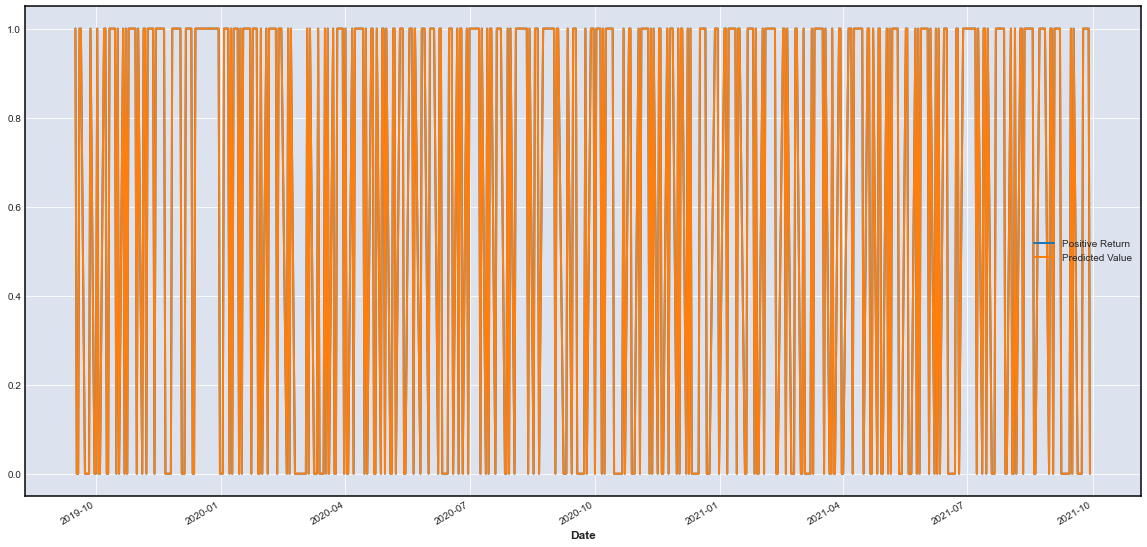

In [217]:
# Plot predicted results vs. actual results
results[["Positive Return", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

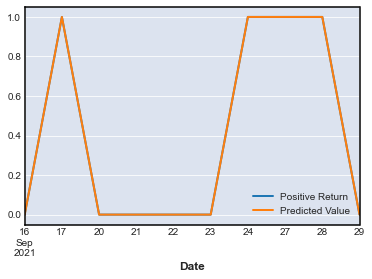

In [218]:
# Plot last 10 records of predicted vs. actual results
results[["Positive Return", "Predicted Value"]].tail(10).plot()

In [219]:
results['Return'] = df_stock['pct_change']
results

Positive Return  Predicted Value    Return
Date                                                  
2019-09-16              1.0              1.0  0.346365
2019-09-17              0.0              0.0 -0.066383
2019-09-18              0.0              0.0 -0.308875
2019-09-19              1.0              1.0  0.253197
2019-09-20              1.0              1.0  0.059809
...                     ...              ...       ...
2021-09-23              0.0              0.0 -0.094462
2021-09-24              1.0              1.0  0.975481
2021-09-27              1.0              1.0  1.215002
2021-09-28              1.0              1.0  0.164721
2021-09-29              0.0              0.0 -0.286092

[515 rows x 3 columns]

<AxesSubplot:xlabel='Date'>

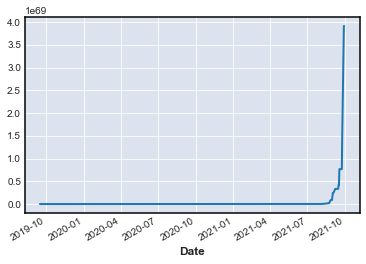

In [220]:
# Calculate cumulative return of the model
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Date'>

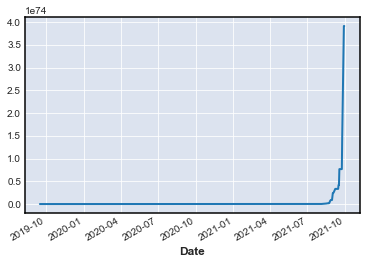

In [221]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [64]:
# Read your api key environment variable
from newsapi import NewsApiClient
load_dotenv()
api_key = os.getenv("NEWSAPI_KEY")

In [65]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [69]:
# Fetch the Bitcoin news articles
stock_headlines = newsapi.get_everything(q=value,
                                        language="en",
                                        page_size=100,
                                        sort_by='relevancy')
#save json
with open('stock.json', 'w') as json_file:
   json.dump(stock_headlines, json_file)

In [70]:
# Fetch the Bitcoin news articles
stock_headlines = newsapi.get_everything(q='fed',
                                        language="en",
                                        page_size=100,
                                        sort_by='relevancy')
#save json
with open('fed.json', 'w') as json_file:
   json.dump(stock_headlines, json_file)

In [71]:
help(newsapi.get_everything)

Help on method get_everything in module newsapi.newsapi_client:

get_everything(q=None, sources=None, domains=None, exclude_domains=None, from_param=None, to=None, language=None, sort_by=None, page=None, page_size=None) method of newsapi.newsapi_client.NewsApiClient instance
        Search through millions of articles from over 5,000 large and small news sources and blogs.
    
        Optional parameters:
            (str) q - return headlines w/ specified coin! Valid values are:
                        'bitcoin', 'trump', 'tesla', 'ethereum', etc
    
            (str) sources - return headlines of news sources! some Valid values are:
                        'bbc-news', 'the-verge', 'abc-news', 'crypto coins news',
                        'ary news','associated press','wired','aftenposten','australian financial review','axios',
                        'bbc news','bild','blasting news','bloomberg','business insider','engadget','google news',
                        'hacker news','info

In [72]:
# Create the Bitcoin sentiment scores DataFrame
tc = pd.read_json ('stock.json')
#parse the json and load into a dataframe
stock_df = json_normalize(stock_headlines['articles'])
#drop all columns except for description
stock_df = stock_df.drop(['author', 'title', 'url','urlToImage','publishedAt','content','source.id','source.name'], axis=1)
#instantiate vader sentiment 
sentiment_title = stock_df.apply(lambda x : analyzer.polarity_scores(x['description']), axis=1)
#add a column for each sentimement metric
stock_df['Comp'] =sentiment_title.apply(lambda x : x.get('compound') )
stock_df['Pos'] =sentiment_title.apply(lambda x : x.get('pos') )
stock_df['Neu'] =sentiment_title.apply(lambda x : x.get('neu') )
stock_df['Neg'] =sentiment_title.apply(lambda x : x.get('neg') )
stock_df

description    Comp    Pos    Neu  \
0   From backpacks to boxer briefs, we have the co...  0.5859  0.179  0.821   
1   The chainless Schaeffler Free Drive system wor...  0.8225  0.211  0.789   
2   The Fed is expected to signal that it will slo...  0.4019  0.097  0.903   
3   Workers in China are fed up with the brutal 12... -0.1027  0.149  0.685   
4   Here’s what you need to know at the end of the...  0.0000  0.000  1.000   
5   One obstacle to Federal Reserve Chair Jerome P... -0.0516  0.064  0.866   
6   U.S. Federal Reserve Chair Jerome Powell and o...  0.0000  0.000  1.000   
7   U.S. consumer and public interest groups on Mo... -0.4939  0.066  0.752   
8   omThe U.S. Federal Reserve is likely to announ...  0.3612  0.077  0.923   
9   * Fed expressing growth concern could be gold ...  0.7351  0.470  0.530   
10     Rebound Fails as Investors Await Fed Statement -0.3400  0.152  0.543   
11  S.Korean stocks end little changed on prospect... -0.0935  0.136  0.702   
12  * Dovish Fed continues to support risky assets...  0.3818  0.310  0.563   
13  US STOCKS-Wall St set to rise on easing Evergr...  0.2500  0.133  0.867   
14  S.Korean stocks end flat, U.S. CPI data in foc...  0.0000  0.000  1.000   
15  PRECIOUS-Gold firms on Evergrande risks; pre-F...  0.0772  0.192  0.640   
16  PRECIOUS-Gold starts week on back foot as Fed ...  0.2023  0.160  0.733   
17  * Gold seen weaker long-term as Fed normalizes... -0.4404  0.000  0.828   
18  PRECIOUS-Gold prices ease as dollar firms on F...  0.3612  0.185  0.815   
19  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
20  "Doing things like this, although not prohibit... -0.6115  0.074  0.735   
21  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
22  * Gold skewed to downside long-term as Fed nor... -0.2500  0.000  0.882   
23  Stocks Plunge Amid China, Fed and Washington C...  0.0000  0.000  1.000   
24  After strong gains in early summer, hiring may...  0.3182  0.189  0.698   
25  The Federal Reserve will release research "soo...  0.3818  0.094  0.906   
26  Sell-off is unfolding and even a "lovey-dovey"... -0.3875  0.000  0.774   
27  Dow and S&P End Four-Day Skid after Fed Statement  0.0000  0.000  1.000   
28  Gold steadied near a four-week high on Monday,...  0.5106  0.161  0.776   
29  Hong Kong shares rose on Monday after U.S. Fed...  0.0516  0.084  0.840   
30  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
31  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
32  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
33  World markets rallied on Thursday after the U....  0.3182  0.128  0.773   
34  U.S. stocks added to gains on Wednesday after ...  0.8074  0.256  0.744   
35  World markets rallied on Thursday after the U....  0.4767  0.140  0.764   
36  * KOSPI falls, foreigners net buyers * Korean ...  0.5574  0.133  0.814   
37  The Federal Reserve may not be able to shield ... -0.8885  0.000  0.752   
38  A look under the hood into what is driving the...  0.4588  0.088  0.912   
39  The Australian and New Zealand dollars were sl... -0.6494  0.000  0.858   
40  The S&P 500 and Nasdaq moved to fresh record h...  0.6908  0.130  0.870   
41  * Silver firms near one-month peak (Recasts, a...  0.0000  0.000  1.000   
42  The dollar rallied to a month-high in Asia on ... -0.7717  0.000  0.796   
43  * Fed's policy statement due at 1800 GMT (Reca...  0.0000  0.000  1.000   
44  Stocks found relief on Wednesday after teeteri...  0.4215  0.123  0.773   
45  U.S. stocks rose sharply higher Wednesday as i...  0.0000  0.000  1.000   
46  World stock markets rallied on Thursday and th... -0.6486  0.058  0.764   
47  World stock markets rallied on Thursday and th... -0.7003  0.000  0.851   
48  Euro zone bond yields sought direction on Mond... -0.3612  0.057  0.811   
49  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
50  The dolla

In [75]:
# Create the Bitcoin sentiment scores DataFrame
tc = pd.read_json ('fed.json')
#parse the json and load into a dataframe
fed_df = json_normalize(stock_headlines['articles'])
#drop all columns except for description
fed_df = fed_df.drop(['author', 'title', 'url','urlToImage','publishedAt','content','source.id','source.name'], axis=1)
#instantiate vader sentiment 
sentiment_title = fed_df.apply(lambda x : analyzer.polarity_scores(x['description']), axis=1)
#add a column for each sentimement metric
fed_df['Comp'] =sentiment_title.apply(lambda x : x.get('compound') )
fed_df['Pos'] =sentiment_title.apply(lambda x : x.get('pos') )
fed_df['Neu'] =sentiment_title.apply(lambda x : x.get('neu') )
fed_df['Neg'] =sentiment_title.apply(lambda x : x.get('neg') )
fed_df

description    Comp    Pos    Neu  \
0   From backpacks to boxer briefs, we have the co...  0.5859  0.179  0.821   
1   The chainless Schaeffler Free Drive system wor...  0.8225  0.211  0.789   
2   The Fed is expected to signal that it will slo...  0.4019  0.097  0.903   
3   Workers in China are fed up with the brutal 12... -0.1027  0.149  0.685   
4   Here’s what you need to know at the end of the...  0.0000  0.000  1.000   
5   One obstacle to Federal Reserve Chair Jerome P... -0.0516  0.064  0.866   
6   U.S. Federal Reserve Chair Jerome Powell and o...  0.0000  0.000  1.000   
7   U.S. consumer and public interest groups on Mo... -0.4939  0.066  0.752   
8   omThe U.S. Federal Reserve is likely to announ...  0.3612  0.077  0.923   
9   * Fed expressing growth concern could be gold ...  0.7351  0.470  0.530   
10     Rebound Fails as Investors Await Fed Statement -0.3400  0.152  0.543   
11  S.Korean stocks end little changed on prospect... -0.0935  0.136  0.702   
12  * Dovish Fed continues to support risky assets...  0.3818  0.310  0.563   
13  US STOCKS-Wall St set to rise on easing Evergr...  0.2500  0.133  0.867   
14  S.Korean stocks end flat, U.S. CPI data in foc...  0.0000  0.000  1.000   
15  PRECIOUS-Gold firms on Evergrande risks; pre-F...  0.0772  0.192  0.640   
16  PRECIOUS-Gold starts week on back foot as Fed ...  0.2023  0.160  0.733   
17  * Gold seen weaker long-term as Fed normalizes... -0.4404  0.000  0.828   
18  PRECIOUS-Gold prices ease as dollar firms on F...  0.3612  0.185  0.815   
19  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
20  "Doing things like this, although not prohibit... -0.6115  0.074  0.735   
21  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
22  * Gold skewed to downside long-term as Fed nor... -0.2500  0.000  0.882   
23  Stocks Plunge Amid China, Fed and Washington C...  0.0000  0.000  1.000   
24  After strong gains in early summer, hiring may...  0.3182  0.189  0.698   
25  The Federal Reserve will release research "soo...  0.3818  0.094  0.906   
26  Sell-off is unfolding and even a "lovey-dovey"... -0.3875  0.000  0.774   
27  Dow and S&P End Four-Day Skid after Fed Statement  0.0000  0.000  1.000   
28  Gold steadied near a four-week high on Monday,...  0.5106  0.161  0.776   
29  Hong Kong shares rose on Monday after U.S. Fed...  0.0516  0.084  0.840   
30  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
31  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
32  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
33  World markets rallied on Thursday after the U....  0.3182  0.128  0.773   
34  U.S. stocks added to gains on Wednesday after ...  0.8074  0.256  0.744   
35  World markets rallied on Thursday after the U....  0.4767  0.140  0.764   
36  * KOSPI falls, foreigners net buyers * Korean ...  0.5574  0.133  0.814   
37  The Federal Reserve may not be able to shield ... -0.8885  0.000  0.752   
38  A look under the hood into what is driving the...  0.4588  0.088  0.912   
39  The Australian and New Zealand dollars were sl... -0.6494  0.000  0.858   
40  The S&P 500 and Nasdaq moved to fresh record h...  0.6908  0.130  0.870   
41  * Silver firms near one-month peak (Recasts, a...  0.0000  0.000  1.000   
42  The dollar rallied to a month-high in Asia on ... -0.7717  0.000  0.796   
43  * Fed's policy statement due at 1800 GMT (Reca...  0.0000  0.000  1.000   
44  Stocks found relief on Wednesday after teeteri...  0.4215  0.123  0.773   
45  U.S. stocks rose sharply higher Wednesday as i...  0.0000  0.000  1.000   
46  World stock markets rallied on Thursday and th... -0.6486  0.058  0.764   
47  World stock markets rallied on Thursday and th... -0.7003  0.000  0.851   
48  Euro zone bond yields sought direction on Mond... -0.3612  0.057  0.811   
49  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
50  The dolla

In [74]:
# Describe the Bitcoin Sentiment
stock_df.describe()

Comp         Pos         Neu         Neg
count  100.000000  100.000000  100.000000  100.000000
mean     0.113949    0.093960    0.838230    0.067780
std      0.450142    0.088097    0.114135    0.080951
min     -0.888500    0.000000    0.530000    0.000000
25%     -0.115300    0.000000    0.773750    0.000000
50%      0.025800    0.089000    0.849500    0.051000
75%      0.476700    0.143000    0.920000    0.120250
max      0.900100    0.470000    1.000000    0.304000

In [76]:
# Describe the Bitcoin Sentiment
fed_df.describe()

Comp         Pos         Neu         Neg
count  100.000000  100.000000  100.000000  100.000000
mean     0.113949    0.093960    0.838230    0.067780
std      0.450142    0.088097    0.114135    0.080951
min     -0.888500    0.000000    0.530000    0.000000
25%     -0.115300    0.000000    0.773750    0.000000
50%      0.025800    0.089000    0.849500    0.051000
75%      0.476700    0.143000    0.920000    0.120250
max      0.900100    0.470000    1.000000    0.304000

In [77]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from string import punctuation
import re

In [78]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [79]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Create a list of the words
    tokens = word_tokenize(re_clean)
    # Convert the words to lowercase
    tokens = [t.lower() for t in tokens]
    # Remove the punctuation
    words = [t.translate(str.maketrans('','',string.punctuation)) for t in tokens]
    # Remove the stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # Lemmatize Words into root words
    tokens = ', '.join([lemmatizer.lemmatize(word) for word in words])
    return tokens

In [80]:
# Create a new tokens column for Bitcoin
stock_df['tokens'] = stock_df.apply(lambda x : tokenizer(x['description']), axis=1)
stock_df

description    Comp    Pos    Neu  \
0   From backpacks to boxer briefs, we have the co...  0.5859  0.179  0.821   
1   The chainless Schaeffler Free Drive system wor...  0.8225  0.211  0.789   
2   The Fed is expected to signal that it will slo...  0.4019  0.097  0.903   
3   Workers in China are fed up with the brutal 12... -0.1027  0.149  0.685   
4   Here’s what you need to know at the end of the...  0.0000  0.000  1.000   
5   One obstacle to Federal Reserve Chair Jerome P... -0.0516  0.064  0.866   
6   U.S. Federal Reserve Chair Jerome Powell and o...  0.0000  0.000  1.000   
7   U.S. consumer and public interest groups on Mo... -0.4939  0.066  0.752   
8   omThe U.S. Federal Reserve is likely to announ...  0.3612  0.077  0.923   
9   * Fed expressing growth concern could be gold ...  0.7351  0.470  0.530   
10     Rebound Fails as Investors Await Fed Statement -0.3400  0.152  0.543   
11  S.Korean stocks end little changed on prospect... -0.0935  0.136  0.702   
12  * Dovish Fed continues to support risky assets...  0.3818  0.310  0.563   
13  US STOCKS-Wall St set to rise on easing Evergr...  0.2500  0.133  0.867   
14  S.Korean stocks end flat, U.S. CPI data in foc...  0.0000  0.000  1.000   
15  PRECIOUS-Gold firms on Evergrande risks; pre-F...  0.0772  0.192  0.640   
16  PRECIOUS-Gold starts week on back foot as Fed ...  0.2023  0.160  0.733   
17  * Gold seen weaker long-term as Fed normalizes... -0.4404  0.000  0.828   
18  PRECIOUS-Gold prices ease as dollar firms on F...  0.3612  0.185  0.815   
19  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
20  "Doing things like this, although not prohibit... -0.6115  0.074  0.735   
21  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
22  * Gold skewed to downside long-term as Fed nor... -0.2500  0.000  0.882   
23  Stocks Plunge Amid China, Fed and Washington C...  0.0000  0.000  1.000   
24  After strong gains in early summer, hiring may...  0.3182  0.189  0.698   
25  The Federal Reserve will release research "soo...  0.3818  0.094  0.906   
26  Sell-off is unfolding and even a "lovey-dovey"... -0.3875  0.000  0.774   
27  Dow and S&P End Four-Day Skid after Fed Statement  0.0000  0.000  1.000   
28  Gold steadied near a four-week high on Monday,...  0.5106  0.161  0.776   
29  Hong Kong shares rose on Monday after U.S. Fed...  0.0516  0.084  0.840   
30  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
31  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
32  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
33  World markets rallied on Thursday after the U....  0.3182  0.128  0.773   
34  U.S. stocks added to gains on Wednesday after ...  0.8074  0.256  0.744   
35  World markets rallied on Thursday after the U....  0.4767  0.140  0.764   
36  * KOSPI falls, foreigners net buyers * Korean ...  0.5574  0.133  0.814   
37  The Federal Reserve may not be able to shield ... -0.8885  0.000  0.752   
38  A look under the hood into what is driving the...  0.4588  0.088  0.912   
39  The Australian and New Zealand dollars were sl... -0.6494  0.000  0.858   
40  The S&P 500 and Nasdaq moved to fresh record h...  0.6908  0.130  0.870   
41  * Silver firms near one-month peak (Recasts, a...  0.0000  0.000  1.000   
42  The dollar rallied to a month-high in Asia on ... -0.7717  0.000  0.796   
43  * Fed's policy statement due at 1800 GMT (Reca...  0.0000  0.000  1.000   
44  Stocks found relief on Wednesday after teeteri...  0.4215  0.123  0.773   
45  U.S. stocks rose sharply higher Wednesday as i...  0.0000  0.000  1.000   
46  World stock markets rallied on Thursday and th... -0.6486  0.058  0.764   
47  World stock markets rallied on Thursday and th... -0.7003  0.000  0.851   
48  Euro zone bond yields sought direction on Mond... -0.3612  0.057  0.811   
49  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
50  The dolla

In [81]:
# Create a new tokens column for Bitcoin
fed_df['tokens'] = fed_df.apply(lambda x : tokenizer(x['description']), axis=1)
fed_df

description    Comp    Pos    Neu  \
0   From backpacks to boxer briefs, we have the co...  0.5859  0.179  0.821   
1   The chainless Schaeffler Free Drive system wor...  0.8225  0.211  0.789   
2   The Fed is expected to signal that it will slo...  0.4019  0.097  0.903   
3   Workers in China are fed up with the brutal 12... -0.1027  0.149  0.685   
4   Here’s what you need to know at the end of the...  0.0000  0.000  1.000   
5   One obstacle to Federal Reserve Chair Jerome P... -0.0516  0.064  0.866   
6   U.S. Federal Reserve Chair Jerome Powell and o...  0.0000  0.000  1.000   
7   U.S. consumer and public interest groups on Mo... -0.4939  0.066  0.752   
8   omThe U.S. Federal Reserve is likely to announ...  0.3612  0.077  0.923   
9   * Fed expressing growth concern could be gold ...  0.7351  0.470  0.530   
10     Rebound Fails as Investors Await Fed Statement -0.3400  0.152  0.543   
11  S.Korean stocks end little changed on prospect... -0.0935  0.136  0.702   
12  * Dovish Fed continues to support risky assets...  0.3818  0.310  0.563   
13  US STOCKS-Wall St set to rise on easing Evergr...  0.2500  0.133  0.867   
14  S.Korean stocks end flat, U.S. CPI data in foc...  0.0000  0.000  1.000   
15  PRECIOUS-Gold firms on Evergrande risks; pre-F...  0.0772  0.192  0.640   
16  PRECIOUS-Gold starts week on back foot as Fed ...  0.2023  0.160  0.733   
17  * Gold seen weaker long-term as Fed normalizes... -0.4404  0.000  0.828   
18  PRECIOUS-Gold prices ease as dollar firms on F...  0.3612  0.185  0.815   
19  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
20  "Doing things like this, although not prohibit... -0.6115  0.074  0.735   
21  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
22  * Gold skewed to downside long-term as Fed nor... -0.2500  0.000  0.882   
23  Stocks Plunge Amid China, Fed and Washington C...  0.0000  0.000  1.000   
24  After strong gains in early summer, hiring may...  0.3182  0.189  0.698   
25  The Federal Reserve will release research "soo...  0.3818  0.094  0.906   
26  Sell-off is unfolding and even a "lovey-dovey"... -0.3875  0.000  0.774   
27  Dow and S&P End Four-Day Skid after Fed Statement  0.0000  0.000  1.000   
28  Gold steadied near a four-week high on Monday,...  0.5106  0.161  0.776   
29  Hong Kong shares rose on Monday after U.S. Fed...  0.0516  0.084  0.840   
30  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
31  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
32  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
33  World markets rallied on Thursday after the U....  0.3182  0.128  0.773   
34  U.S. stocks added to gains on Wednesday after ...  0.8074  0.256  0.744   
35  World markets rallied on Thursday after the U....  0.4767  0.140  0.764   
36  * KOSPI falls, foreigners net buyers * Korean ...  0.5574  0.133  0.814   
37  The Federal Reserve may not be able to shield ... -0.8885  0.000  0.752   
38  A look under the hood into what is driving the...  0.4588  0.088  0.912   
39  The Australian and New Zealand dollars were sl... -0.6494  0.000  0.858   
40  The S&P 500 and Nasdaq moved to fresh record h...  0.6908  0.130  0.870   
41  * Silver firms near one-month peak (Recasts, a...  0.0000  0.000  1.000   
42  The dollar rallied to a month-high in Asia on ... -0.7717  0.000  0.796   
43  * Fed's policy statement due at 1800 GMT (Reca...  0.0000  0.000  1.000   
44  Stocks found relief on Wednesday after teeteri...  0.4215  0.123  0.773   
45  U.S. stocks rose sharply higher Wednesday as i...  0.0000  0.000  1.000   
46  World stock markets rallied on Thursday and th... -0.6486  0.058  0.764   
47  World stock markets rallied on Thursday and th... -0.7003  0.000  0.851   
48  Euro zone bond yields sought direction on Mond... -0.3612  0.057  0.811   
49  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
50  The dolla

In [82]:
from collections import Counter
from nltk import ngrams
import nltk, re, string, collections
from collections import Counter
from nltk import ngrams
from nltk.collocations import *
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
#import janitor as jn
#import ConfigParser

In [83]:
# Generate the Bitcoin N-grams where N=2
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
#determine counts in the token column
sparse_matrix = word_vectorizer.fit_transform(stock_df['tokens'])
#sum counts
frequencies = sum(sparse_matrix).toarray()[0]
#create dataframe with ngram and count
stock_df_freq_2 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
stock_df_freq_2 = stock_df_freq_2.sort_values(by='frequency', ascending=False)
stock_df_freq_2.head(10)

frequency
federal reserve          48
central bank             25
jerome powell            16
chair jerome             12
interest rate             9
bank president            7
update price              7
china evergrande          7
reserve chair             7
add comment               7

In [84]:
# Generate the Bitcoin N-grams where N=2
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
#determine counts in the token column
sparse_matrix = word_vectorizer.fit_transform(fed_df['tokens'])
#sum counts
frequencies = sum(sparse_matrix).toarray()[0]
#create dataframe with ngram and count
fed_df_freq_2 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
fed_df_freq_2 = fed_df_freq_2.sort_values(by='frequency', ascending=False)
fed_df_freq_2.head(10)

frequency
federal reserve          48
central bank             25
jerome powell            16
chair jerome             12
interest rate             9
bank president            7
update price              7
china evergrande          7
reserve chair             7
add comment               7

In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [86]:
#join all text in tokens column into 1 string
corpus_stock = stock_df['tokens'].str.cat(sep=', ')

In [87]:
#join all text in tokens column into 1 string
corpus_fed = fed_df['tokens'].str.cat(sep=', ')

In [88]:
# Generate the Bitcoin word cloud
#create word cloud
wc = WordCloud(background_color="white", max_words=200)
wc.generate(corpus_stock)
f = plt.figure(figsize=(150,150))
f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title(f"{value} WORD CLOUD",fontsize=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [89]:
# Generate the Bitcoin word cloud
#create word cloud
wc = WordCloud(background_color="white", max_words=200)
wc.generate(corpus_fed)
f = plt.figure(figsize=(150,150))
f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title(f"fed WORD CLOUD",fontsize=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Weekly Analysis

In [225]:
stock_df_wk = stock.history(period="20y", interval='1wk')
stock_df.index.duplicated().sum()
df_stock_wk = stock_df_wk.loc[~stock_df_wk.index.duplicated(keep='first')]
df_stock_wk.dropna(inplace=True)
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2001-10-01   70.819968   74.275764   70.090638   73.089752  134806500.0   
2001-10-08   72.435392   75.182312   71.924180   74.637016  103300800.0   
2001-10-15   74.043992   75.761669   72.258161   73.171524   99714900.0   
2001-10-22   73.137488   76.197946   72.755779   75.195969  101759500.0   
2001-10-29   75.086864   75.352694   71.951425   74.466591  120413000.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82329213.0   

            Dividends  Stock Splits  
Date                                 
2001-10-01        0.0             0  
2001-10-08        0.0             0  
2001-10-15        0.0             0  
2001-10-22        0.0             0  
2001-10-29        0.0             0  
...               ...           ...  
2021-09-06        0.0             0  
2021-09-13        0.0             0  
2021-09-20        0.0             0  
2021-09-27        0.0             0  
2021-09-29        0.0             0  

[1045 rows x 7 columns]

In [226]:
# calculate Bollinger Bands on weekly data
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_wk = df_stock_wk['Close'].ewm(span=length).mean()
df_stock_wk['Moving average weekly'] = m_avg_wk
# standard deviation
m_std_wk = df_stock_wk['Close'].rolling(window=length).std(ddof=0)
# upper Bollinger Bands
df_stock_wk['upper_BB'] = m_avg_wk + mult * m_std_wk
# lower Bollinger Bands 
df_stock_wk['lower_BB'] = m_avg_wk - mult * m_std_wk

In [227]:
#Stacked Moving averages weekly
m_avg_08_wk = df_stock_wk['Close'].ewm(span=8).mean()
m_avg_21_wk = df_stock_wk['Close'].ewm(span=21).mean()
m_avg_34_wk = df_stock_wk['Close'].ewm(span=34).mean()
m_avg_55_wk = df_stock_wk['Close'].ewm(span=55).mean()
m_avg_89_wk = df_stock_wk['Close'].ewm(span=89).mean()

df_stock_wk['m_avg_08'] = m_avg_08_wk
df_stock_wk['m_avg_21'] = m_avg_21_wk
df_stock_wk['m_avg_34'] = m_avg_34_wk
df_stock_wk['m_avg_55'] = m_avg_55_wk
df_stock_wk['m_avg_89'] = m_avg_89_wk

In [228]:
# calculate Keltner Channel weekly
# first we need to calculate True Range
df_stock_wk['tr0'] = abs(df_stock_wk["High"] - df_stock_wk["Low"])
df_stock_wk['tr1'] = abs(df_stock_wk["High"] - df_stock_wk["Close"].shift())
df_stock_wk['tr2'] = abs(df_stock_wk["Low"] - df_stock_wk["Close"].shift())
df_stock_wk['tr'] = df_stock_wk[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma_wk = df_stock_wk['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_wk['upper_KC'] = m_avg_wk + range_ma_wk * mult_KC
# lower Keltner Channel
df_stock_wk['lower_KC'] = m_avg_wk - range_ma_wk * mult_KC

In [229]:
#ADX Calculations weekly

plus_dm_wk = df_stock_wk["High"].diff()
minus_dm_wk = df_stock_wk["Low"].diff()
plus_dm_wk[plus_dm_wk < 0] = 0
minus_dm_wk[minus_dm_wk > 0] = 0

df_stock_wk['atr'] = df_stock_wk['tr'].ewm(span=14).mean()
df_stock_wk['plus_di'] = 100 * (plus_dm_wk.ewm(alpha = 1/14).mean() / df_stock_wk['atr'])
df_stock_wk['minus_di'] = abs(100 * (minus_dm_wk.ewm(alpha = 1/14).mean() / df_stock_wk['atr']))
dx_wk = (abs(df_stock_wk['plus_di'] - df_stock_wk['minus_di']) / abs(df_stock_wk['plus_di'] + df_stock_wk['minus_di'])) * 100
adx_wk = ((dx_wk.shift(1) * (14 - 1)) + dx_wk) / 14
df_stock_wk['adx'] = adx_wk.ewm(alpha = 1/14).mean()

In [230]:
# check for 'squeeze' weekly
df_stock_wk['squeeze_on'] = (df_stock_wk['lower_BB'] > df_stock_wk['lower_KC']) & (df_stock_wk['upper_BB'] < df_stock_wk['upper_KC'])
df_stock_wk['squeeze_off'] = (df_stock_wk['lower_BB'] < df_stock_wk['lower_KC']) & (df_stock_wk['upper_BB'] > df_stock_wk['upper_KC'])

In [231]:
# Momentum weekly
highest_wk = df_stock_wk['High'].rolling(window = length_KC).max()
lowest_wk = df_stock_wk['Low'].rolling(window = length_KC).min()
m1_wk = (highest_wk + lowest_wk) / 2
df_stock_wk['value'] = (df_stock_wk['Close'] - (m1_wk + m_avg_wk)/2)
fit_y_wk = np.array(range(0,length_KC))
df_stock_wk['value'] = df_stock_wk['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_wk, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_wk, x, 1)[1], raw=True)

df_stock_wk[['squeeze_on', 'squeeze_off']] = (df_stock_wk[['squeeze_on', 'squeeze_off']] == True).astype(int)

df_stock_wk["pct_change"] = df_stock_wk['Close'].pct_change()

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_wk =  [
    (df_stock_wk['pct_change'] > 0),
    (df_stock_wk['pct_change'] < 0)
]

label = [1, 0]
df_stock_wk['profitable?'] = np.select(conditions_wk, label) 
df_stock_wk.dropna(inplace=True)
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-07-08   68.130006   68.625593   62.169145   63.222275  196756600.0   
2002-07-15   63.077727   64.220342   58.025454   58.307663  289709500.0   
2002-07-22   57.887821   59.147451   53.468800   58.920303  388024300.0   
2002-07-29   60.228079   63.015781   58.934038   59.739372  264039800.0   
2002-08-05   59.532869   63.284221   57.509209   62.836811  245429700.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82329213.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-07-08        0.0             0              72.166118   81.236356   
2002-07-15        0.0             0              70.826243   81.974531   
2002-07-22        0.0             0              69.676803   81.893437   
2002-07-29        0.0             0              68.718661   81.460942   
2002-08-05        0.0             0              68.152216   80.798934   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548194  454.982262   
2021-09-13        0.0             0             430.542691  455.297327   
2021-09-20        0.0             0             431.815769  456.520457   
2021-09-27        0.0             0             432.066649  455.250063   
2021-09-29        0.0             0             432.293636  453.320628   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-07-08   63.095879   68.858658   72.319273   73.561690   74.336968   
2002-07-15   59.677955   66.513931   71.021798   72.609604   73.605753   
2002-07-22   57.460170   64.826424   69.903091   71.759662   72.942410   
2002-07-29   55.976380   63.695950   68.964959   71.017019   72.351614   
2002-08-05   55.505498   63.505028   68.400106   70.513959   71.929667   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114126  442.495578  428.426622  414.074232  393.689219   
2021-09-13  405.788056  441.938875  429.477876  415.555157  395.342833   
2021-09-20  407.111080  442.376904  430.789888  417.175434  397.077375   
2021-09-27  408.883235  440.615372  431.122626  418.162553  398.412112   
2021-09-29  411.266644  439.245292  431.425116  419.093265  399.699180   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-07-08   74.786565   6.456448  0.268491   6.187957   6.456448   79.139231   
2002-07-15   74.187103   6.194888  0.998067   5.196821   6.194888   78.300939   
2002-07-22   73.639485   5.678651  0.839788   4.838863   5.678651   77.510422   
2002-07-29   73.147604   4.081743  4.095478   0.013735   4.095478   76.585263   
2002-08-05   72.787478   5.775012  3.544848   2.230163   5.775012   76.358332   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488687   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077615   7.874796  3.468905   4.405891   7.874796  447.745235   
2021-09-20  371.718335  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.112372  11.109985  0.139984  10.970001  11.109985  450.953216   
2021-09-29  374.475431   3.190002  2.589996   0.600006   3.190002  450.043243   

              lower_KC       atr    plus_di   minus_di        

In [232]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_wk = (df_stock_wk['squeeze_off'][-2] == 0) | (df_stock_wk['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_wk = df_stock_wk['value'][-1] > 0

enter_long_wk = long_cond1_wk and long_cond2_wk
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_wk = (df_stock_wk['squeeze_off'][-2] == 0) | (df_stock_wk['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_wk = df_stock_wk['value'][-1] < 0
enter_short_wk = short_cond1_wk and short_cond2_wk

In [233]:
ohcl_wk = df_stock_wk[['Open', 'High', 'Close', 'Low']]
ohcl_wk.head()

Open       High      Close        Low
Date                                                  
2002-07-08  68.130006  68.625593  63.222275  62.169145
2002-07-15  63.077727  64.220342  58.307663  58.025454
2002-07-22  57.887821  59.147451  58.920303  53.468800
2002-07-29  60.228079  63.015781  59.739372  58.934038
2002-08-05  59.532869  63.284221  62.836811  57.509209

In [234]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock_wk['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock_wk['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock_wk['value'][ind-1]:
      color='red'
  colors.append(color)

In [235]:
df_stock_wk['colors'] = colors

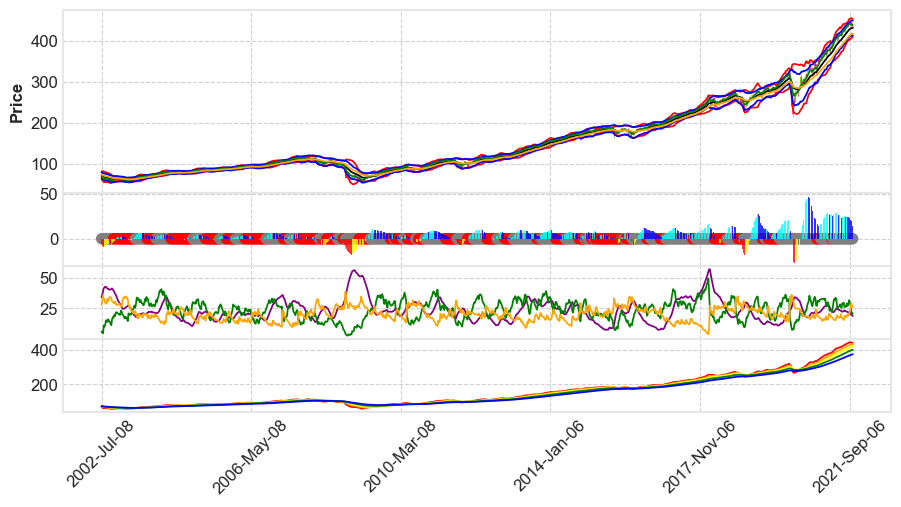

In [236]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
        mpf.make_addplot(df_stock_wk['m_avg_08'], color='green'),
        mpf.make_addplot(df_stock_wk['m_avg_34'], color='orange'),
        mpf.make_addplot(df_stock_wk[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)

In [237]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs_wk = stochastics( df_stock_wk, 'Low', 'High', 'Close', 14, 3 )
slow_k_wk = stochs_wk['k_slow'].values
fast_k_wk = stochs_wk['k_fast'].values
df_stock_wk["slow_K"] = slow_k_wk
df_stock_wk['fast_K'] = fast_k_wk
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-07-08   68.130006   68.625593   62.169145   63.222275  196756600.0   
2002-07-15   63.077727   64.220342   58.025454   58.307663  289709500.0   
2002-07-22   57.887821   59.147451   53.468800   58.920303  388024300.0   
2002-07-29   60.228079   63.015781   58.934038   59.739372  264039800.0   
2002-08-05   59.532869   63.284221   57.509209   62.836811  245429700.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82329213.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-07-08        0.0             0              72.166118   81.236356   
2002-07-15        0.0             0              70.826243   81.974531   
2002-07-22        0.0             0              69.676803   81.893437   
2002-07-29        0.0             0              68.718661   81.460942   
2002-08-05        0.0             0              68.152216   80.798934   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548194  454.982262   
2021-09-13        0.0             0             430.542691  455.297327   
2021-09-20        0.0             0             431.815769  456.520457   
2021-09-27        0.0             0             432.066649  455.250063   
2021-09-29        0.0             0             432.293636  453.320628   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-07-08   63.095879   68.858658   72.319273   73.561690   74.336968   
2002-07-15   59.677955   66.513931   71.021798   72.609604   73.605753   
2002-07-22   57.460170   64.826424   69.903091   71.759662   72.942410   
2002-07-29   55.976380   63.695950   68.964959   71.017019   72.351614   
2002-08-05   55.505498   63.505028   68.400106   70.513959   71.929667   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114126  442.495578  428.426622  414.074232  393.689219   
2021-09-13  405.788056  441.938875  429.477876  415.555157  395.342833   
2021-09-20  407.111080  442.376904  430.789888  417.175434  397.077375   
2021-09-27  408.883235  440.615372  431.122626  418.162553  398.412112   
2021-09-29  411.266644  439.245292  431.425116  419.093265  399.699180   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-07-08   74.786565   6.456448  0.268491   6.187957   6.456448   79.139231   
2002-07-15   74.187103   6.194888  0.998067   5.196821   6.194888   78.300939   
2002-07-22   73.639485   5.678651  0.839788   4.838863   5.678651   77.510422   
2002-07-29   73.147604   4.081743  4.095478   0.013735   4.095478   76.585263   
2002-08-05   72.787478   5.775012  3.544848   2.230163   5.775012   76.358332   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488687   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077615   7.874796  3.468905   4.405891   7.874796  447.745235   
2021-09-20  371.718335  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.112372  11.109985  0.139984  10.970001  11.109985  450.953216   
2021-09-29  374.475431   3.190002  2.589996   0.600006   3.190002  450.043243   

              lower_KC       atr    plus_di   minus_di        

In [238]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock_wk['rsi_14'] = get_rsi(df_stock_wk['Close'], 14)
df_stock_wk = df_stock_wk.dropna()
df_stock_wk['Overbought'] = 70
df_stock_wk['Oversold'] = 30
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-10-21   60.926747   62.848856   60.546471   62.364868  240391200.0   
2002-10-28   63.021718   63.118514   60.152379   62.413277  234112400.0   
2002-11-04   63.471102   64.349186   61.894691   61.984577  240841900.0   
2002-11-11   61.887833   63.298304   60.463531   63.194592  206170000.0   
2002-11-18   63.713125   65.178904   62.060664   64.591209  186071800.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-29  435.190002  437.040009  433.850006  434.450012   82329213.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-10-21        0.0             0              62.966999   70.810381   
2002-10-28        0.0             0              62.914088   70.022445   
2002-11-04        0.0             0              62.825295   69.352883   
2002-11-11        0.0             0              62.860563   68.732702   
2002-11-18        0.0             0              63.025794   68.193267   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548194  454.982262   
2021-09-13        0.0             0             430.542691  455.297327   
2021-09-20        0.0             0             431.815769  456.520457   
2021-09-27        0.0             0             432.066649  455.250063   
2021-09-29        0.0             0             432.293636  453.320628   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-10-21   55.123618   60.390771   63.196572   65.587739   67.654152   
2002-10-28   55.805731   60.840217   63.125051   65.399772   67.440040   
2002-11-04   56.297708   61.094519   63.020958   65.197968   67.218301   
2002-11-11   56.988423   61.561202   63.036800   65.079819   67.055558   
2002-11-18   57.858320   62.234537   63.178575   65.051056   66.956354   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114126  442.495578  428.426622  414.074232  393.689219   
2021-09-13  405.788056  441.938875  429.477876  415.555157  395.342833   
2021-09-20  407.111080  442.376904  430.789888  417.175434  397.077375   
2021-09-27  408.883235  440.615372  431.122626  418.162553  398.412112   
2021-09-29  411.266644  439.245292  431.425116  419.093265  399.699180   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-10-21   69.094998   2.302385  1.562571   0.739815   2.302385   70.722776   
2002-10-28   68.889408   2.966135  0.753646   2.212489   2.966135   70.503363   
2002-11-04   68.678754   2.454495  1.935909   0.518586   2.454495   70.169936   
2002-11-11   68.512817   2.834773  1.313726   1.521046   2.834773   70.052370   
2002-11-18   68.395104   3.118240  1.984312   1.133928   3.118240   70.130467   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488687   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077615   7.874796  3.468905   4.405891   7.874796  447.745235   
2021-09-20  371.718335  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.112372  11.109985  0.139984  10.970001  11.109985  450.953216   
2021-09-29  374.475431   3.190002  2.589996   0.600006   3.190002  450.043243   

              lower_KC       atr    plus_di   minus_di        

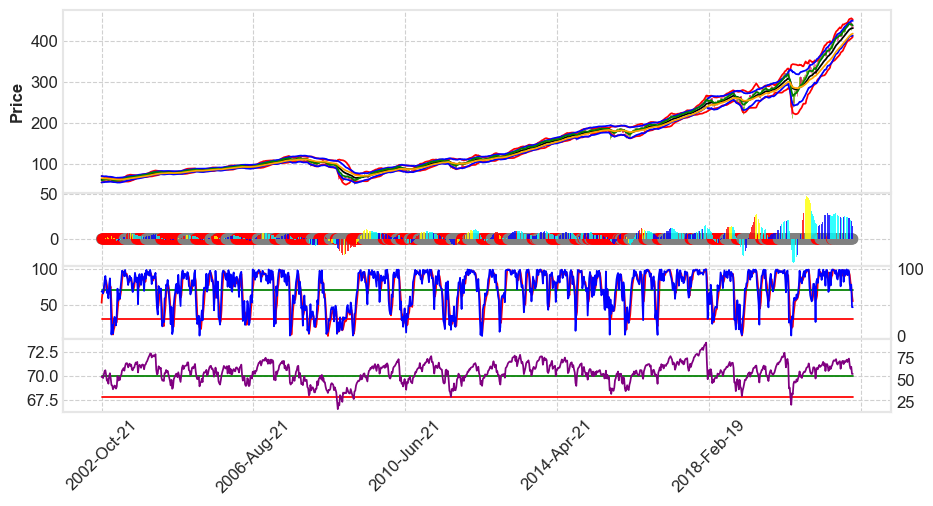

In [240]:
apds2 = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
         mpf.make_addplot(df_stock_wk['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock_wk['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock_wk['slow_K'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_wk['fast_K'], panel=2, color = 'blue'),
         mpf.make_addplot(df_stock_wk['Overbought'], panel=2, color = 'green'),
         mpf.make_addplot(df_stock_wk['Oversold'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_wk['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock_wk['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock_wk['rsi_14'], panel=3, color='purple')]
fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)

In [82]:
for i in range(2,df_stock_wk.shape[0]):
    current = df_stock_wk.iloc[i,:]
    prev = df_stock_wk.iloc[i-1,:]
    prev_2 = df_stock_wk.iloc[i-2,:]
    realbody = abs(current['Open'] - current['Close'])
    candle_range = current['High'] - current['Low']
    idx = df_stock_wk.index[i]  
# Bullish swing
    df_stock_wk.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
# Bearish swing
    df_stock_wk.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
# Bullish pinbar
    df_stock_wk.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
# Bearish pinbar
    df_stock_wk.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']
    
  # Inside bar
    df_stock_wk.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']
    
  # Outside bar
    df_stock_wk.loc[idx,'Outside bar'] = current['High'] > prev['High'] and current['Low'] < prev['Low']
  
  # Bullish engulfing
    df_stock_wk.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
# Bearish engulfing
    df_stock_wk.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']

df_stock_wk.fillna(False, inplace=True)

In [83]:
columns = ['Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing','Bearish engulfing']


def convert(df):
    patterns = []
    for i in columns:
        if df[i]:
            patterns.append(i)
    #df['patterns'] = patterns
    if not patterns:
        patterns.append('No pattern')
    return patterns

In [84]:
#df_stock_dow.apply(convert, axis=1)
df_stock_wk['pattern'] = df_stock_wk.apply(convert, axis = 1)

In [88]:
df_stock_wk['pattern'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[No pattern]                                  371
[Bullish swing]                               152
[Bearish swing]                               126
[Outside bar]                                  81
[Bearish pinbar]                               52
[Bearish swing, Bullish pinbar]                36
[Bearish swing, Inside bar]                    31
[Bullish pinbar]                               28
[Bullish swing, Inside bar]                    27
[Bullish swing, Bearish swing, Inside bar]     18
[Bullish swing, Bearish pinbar]                17
[Bullish pinbar, Outside bar]                  16
[Outside bar, Bearish engulfing]               13
[Outside bar, Bullish engulfing]               10
[Bearish pinbar, Outside bar]                   7
[Inside bar]                                    5
Name: pattern, dtype: int64

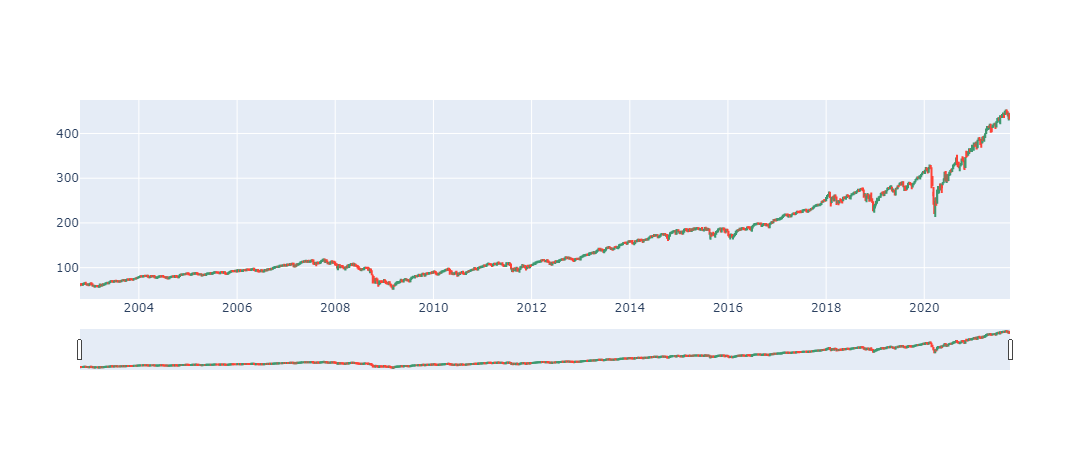

In [89]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df_stock_wk.index,
                open=df_stock_wk['Open'],
                high=df_stock_wk['High'],
                low=df_stock_wk['Low'],
                close=df_stock_wk['Close'])])
fig.update_traces(text=df_stock_wk['pattern'], selector=dict(type='candlestick'))
fig.show()

In [90]:
today = df_stock_wk['pattern'][-1]
for i in today:
    print(f'Todays pattern is {i}, {pattern_dict[i]}')

Todays pattern is Inside bar, trend change


In [91]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker_wk(index):
    if (df_stock_wk['m_avg_08'][index] > df_stock_wk['m_avg_21'][index] > df_stock_wk['m_avg_34'][index] > df_stock_wk['m_avg_55'][index] > df_stock_wk['m_avg_89'][index]):
        print('Positive momentum')
    elif (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_21'][index] < df_stock_wk['m_avg_34'][index] < df_stock_wk['m_avg_55'][index] < df_stock_wk['m_avg_89'][index]):
        print('Negative momentum')
    else:
        print('neutral')

In [92]:
df_stock_wk['ADX_trend'] = 20

def ADX_trend_flag_wk(index):
    if (df_stock_wk['adx'][index] > df_stock_wk['ADX_trend'][index]) and (df_stock_wk['plus_di'][index] > df_stock_wk['minus_di'][index]):
        print('positive trend')
    elif (df_stock_wk['adx'][index] > df_stock_wk['ADX_trend'][index]) and (df_stock_wk['plus_di'][index] < df_stock_wk['minus_di'][index]):
        print('negative trend')
    elif (df_stock_wk['adx'][index] < df_stock_wk['ADX_trend'][index]):
        print('neutral or sideways trend')

In [93]:
def warning_wk(index):
    if (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_21'][index]):
        print('Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.  This is especially bad with this weekly chart')
    if (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_34'][index]):
        print('As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema')
    elif (df_stock_wk['m_avg_08'][index] > df_stock_wk['m_avg_21'][index]):
        print('Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger')

In [94]:
def squeeze_momentum_wk(index):
    if (df_stock_wk['squeeze_on'][index] == 1.0):
        print('squeeze is on')
    else:
        print('squeeze is off')
    
    if (df_stock_wk['colors'][index] == 'cyan'):
        print('stock is in a mark up mode')
    elif (df_stock_wk['colors'][index] == 'blue'):
        print('stock is in a distribution mode')
    elif (df_stock_wk['colors'][index] == 'yellow'):
        print('stock is in an accumulation mode')
    elif (df_stock_wk['colors'][index] == 'red'):
        print('stock is in a mark down mode')

In [95]:
momentum_checker_wk(-1)

Positive momentum


In [96]:
ADX_trend_flag_wk(-1)

neutral or sideways trend


In [97]:
warning_wk(-1)

Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger


In [98]:
squeeze_momentum_wk(-1)

squeeze is off
stock is in a distribution mode


In [99]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
df_stock_wk['value_threshold'] = abs(df_stock_wk['value'].min()*.10)
df_stock_wk['squeeze_threshold'] = 1.0
df_stock_wk["squeeze_entry"] = np.logical_and(np.greater(df_stock_wk["value"], df_stock_wk['value_threshold']), 
                                           np.equal(df_stock_wk['squeeze_on'], df_stock_wk['squeeze_threshold']))
df_stock_wk['squeeze_entry'] = df_stock_wk['squeeze_entry'].astype(float)
df_stock_wk['Entry/Exit'] = df_stock_wk['squeeze_entry'].diff()
df_stock_wk.dropna(inplace=True)

In [100]:
def implement_bb_strategy_wk(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal


In [101]:
buy_price_wk, sell_price_wk, squeeze_signal_wk = implement_bb_strategy_wk(df_stock_wk["Close"], df_stock_wk['squeeze_on'], df_stock_wk['value'], 
                                                              df_stock_wk['upper_KC'], df_stock_wk['value_threshold'], df_stock_wk['colors'], 1.50)

In [102]:
df_stock_wk['buy_price'] =  buy_price_wk
df_stock_wk['sell_price'] = sell_price_wk
df_stock_wk['squeeze_signal'] = squeeze_signal_wk
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-10-28   63.021722   63.118518   60.152383   62.413280  234112400.0   
2002-11-04   63.471141   64.349225   61.894729   61.984615  240841900.0   
2002-11-11   61.887792   63.298262   60.463491   63.194550  206170000.0   
2002-11-18   63.713125   65.178904   62.060664   64.591209  186071800.0   
2002-11-25   64.598103   65.649038   63.346659   64.978378  133280800.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  433.720001  191271400.0   
2021-09-29  435.190002  437.040009  434.029999  434.600006   36260199.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-10-28        0.0             0              62.914089   70.022460   
2002-11-04        0.0             0              62.825301   69.352904   
2002-11-11        0.0             0              62.860563   68.732715   
2002-11-18        0.0             0              63.025794   68.193269   
2002-11-25        0.0             0              63.212171   68.569242   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548194  454.982262   
2021-09-13        0.0             0             430.542692  455.297327   
2021-09-20        0.0             0             431.815769  456.520458   
2021-09-27        0.0             0             431.997125  455.177037   
2021-09-29        0.0             0             432.245018  453.275711   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-10-28   55.805719   60.840221   63.125052   65.399773   67.440042   
2002-11-04   56.297697   61.094531   63.020963   65.197972   67.218304   
2002-11-11   56.988411   61.561202   63.036800   65.079820   67.055559   
2002-11-18   57.858319   62.234537   63.178576   65.051057   66.956356   
2002-11-25   57.855099   62.844280   63.342684   65.046786   66.877091   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114127  442.495578  428.426623  414.074233  393.689219   
2021-09-13  405.788056  441.938875  429.477877  415.555158  395.342833   
2021-09-20  407.111080  442.376904  430.789888  417.175435  397.077375   
2021-09-27  408.817212  440.453148  431.056262  418.120839  398.386040   
2021-09-29  411.214325  439.152450  431.378421  419.062505  399.679396   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-10-28   68.889410   2.966135  0.753635   2.212501   2.966135   70.503370   
2002-11-04   68.678757   2.454496  1.935945   0.518551   2.454496   70.169947   
2002-11-11   68.512818   2.834771  1.313646   1.521124   2.834771   70.052375   
2002-11-18   68.395106   3.118240  1.984354   1.133886   3.118240   70.130471   
2002-11-25   68.293341   2.302379  1.057829   1.244551   2.302379   70.088902   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488687   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077614   7.874796  3.468905   4.405891   7.874796  447.745235   
2021-09-20  371.718334  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.096149  11.109985  0.139984  10.970001  11.109985  450.883691   
2021-09-29  374.462901   3.010010  3.320007   0.309998   3.320007  450.018262   

              lower_KC       atr    plus_di   minus_di        

In [103]:
# Visualize exit position relative to close price
exit = df_stock_wk[df_stock_wk['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_wk[df_stock_wk['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_wk[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot


:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [104]:
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-10-28   63.021722   63.118518   60.152383   62.413280  234112400.0   
2002-11-04   63.471141   64.349225   61.894729   61.984615  240841900.0   
2002-11-11   61.887792   63.298262   60.463491   63.194550  206170000.0   
2002-11-18   63.713125   65.178904   62.060664   64.591209  186071800.0   
2002-11-25   64.598103   65.649038   63.346659   64.978378  133280800.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  433.720001  191271400.0   
2021-09-29  435.190002  437.040009  434.029999  434.600006   36260199.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-10-28        0.0             0              62.914089   70.022460   
2002-11-04        0.0             0              62.825301   69.352904   
2002-11-11        0.0             0              62.860563   68.732715   
2002-11-18        0.0             0              63.025794   68.193269   
2002-11-25        0.0             0              63.212171   68.569242   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548194  454.982262   
2021-09-13        0.0             0             430.542692  455.297327   
2021-09-20        0.0             0             431.815769  456.520458   
2021-09-27        0.0             0             431.997125  455.177037   
2021-09-29        0.0             0             432.245018  453.275711   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-10-28   55.805719   60.840221   63.125052   65.399773   67.440042   
2002-11-04   56.297697   61.094531   63.020963   65.197972   67.218304   
2002-11-11   56.988411   61.561202   63.036800   65.079820   67.055559   
2002-11-18   57.858319   62.234537   63.178576   65.051057   66.956356   
2002-11-25   57.855099   62.844280   63.342684   65.046786   66.877091   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114127  442.495578  428.426623  414.074233  393.689219   
2021-09-13  405.788056  441.938875  429.477877  415.555158  395.342833   
2021-09-20  407.111080  442.376904  430.789888  417.175435  397.077375   
2021-09-27  408.817212  440.453148  431.056262  418.120839  398.386040   
2021-09-29  411.214325  439.152450  431.378421  419.062505  399.679396   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-10-28   68.889410   2.966135  0.753635   2.212501   2.966135   70.503370   
2002-11-04   68.678757   2.454496  1.935945   0.518551   2.454496   70.169947   
2002-11-11   68.512818   2.834771  1.313646   1.521124   2.834771   70.052375   
2002-11-18   68.395106   3.118240  1.984354   1.133886   3.118240   70.130471   
2002-11-25   68.293341   2.302379  1.057829   1.244551   2.302379   70.088902   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488687   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077614   7.874796  3.468905   4.405891   7.874796  447.745235   
2021-09-20  371.718334  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.096149  11.109985  0.139984  10.970001  11.109985  450.883691   
2021-09-29  374.462901   3.010010  3.320007   0.309998   3.320007  450.018262   

              lower_KC       atr    plus_di   minus_di        

In [105]:
position = []
#df_stock_wk = df_stock_wk.loc[~df_stock_wk.index.duplicated(keep='first')]
for i in range(len(squeeze_signal_wk)):
    if df_stock_wk['squeeze_signal'][i] < 1.0:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_wk['Close'])):
    if df_stock_wk['squeeze_signal'][i] == 1.0:
        position[i] = 1.0
    elif df_stock_wk['squeeze_signal'][i] == -1.0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_wk['Close']
squeeze_signal_wk = pd.DataFrame(squeeze_signal_wk).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_wk.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_wk.index)

frames = [close_price, squeeze_signal_wk, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date       Close  squeeze_signal  squeeze_position
0   2002-10-28   62.413280             1.0               1.0
1   2002-11-04   61.984615             0.0               1.0
2   2002-11-11   63.194550             0.0               1.0
3   2002-11-18   64.591209             0.0               1.0
4   2002-11-25   64.978378             0.0               1.0
..         ...         ...             ...               ...
984 2021-09-06  444.017517             0.0               0.0
985 2021-09-13  439.990417             0.0               0.0
986 2021-09-20  443.910004             0.0               0.0
987 2021-09-27  433.720001             0.0               0.0
988 2021-09-29  434.600006             0.0               0.0

[989 rows x 4 columns]

In [106]:
stock_ret = pd.DataFrame(np.diff(df_stock_wk['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_wk['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_wk['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in spy is 421676.33
Profit percentage of the Squeeze strategy : 421%
421676.32510757446


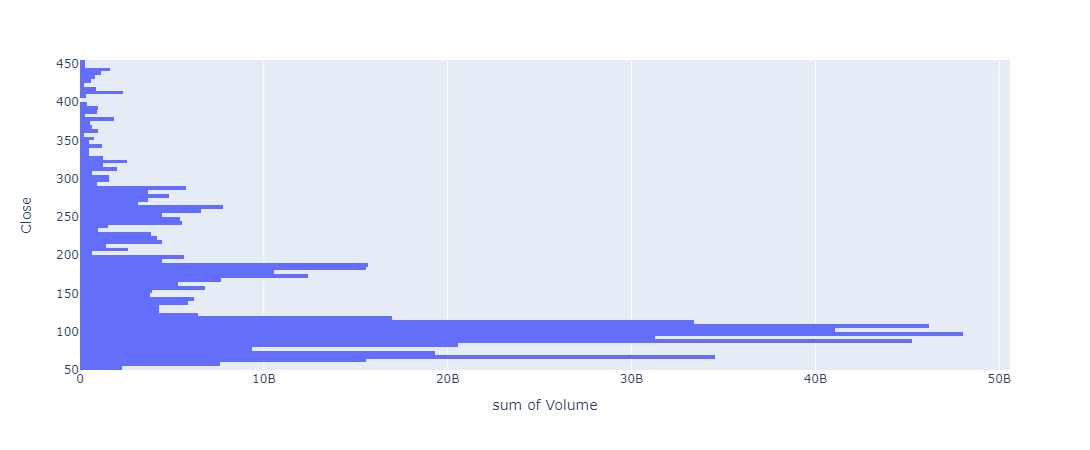

In [107]:
px.histogram(df_stock_wk, x='Volume', y='Close', nbins=150, orientation='h').show()

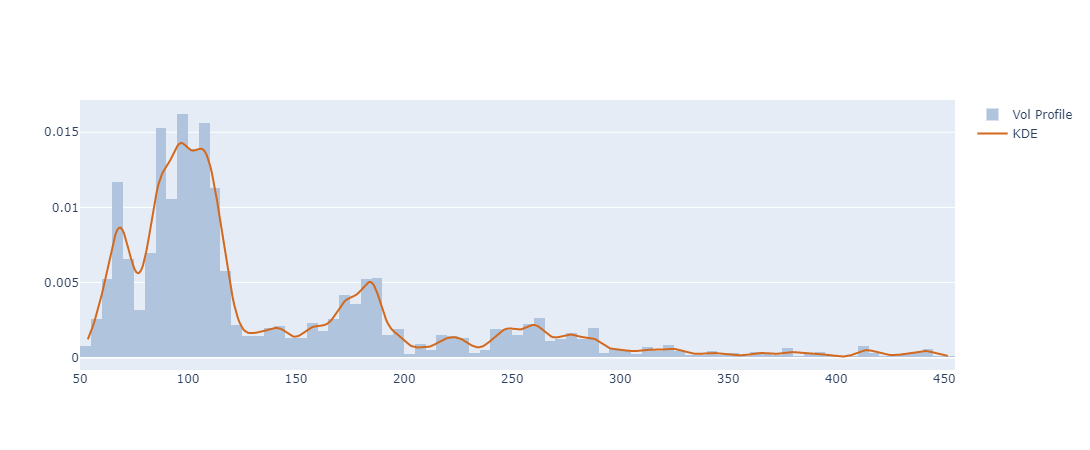

In [108]:
kde_factor = 0.05
num_samples = 500
close = df_stock_wk['Close']
volume = df_stock_wk['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

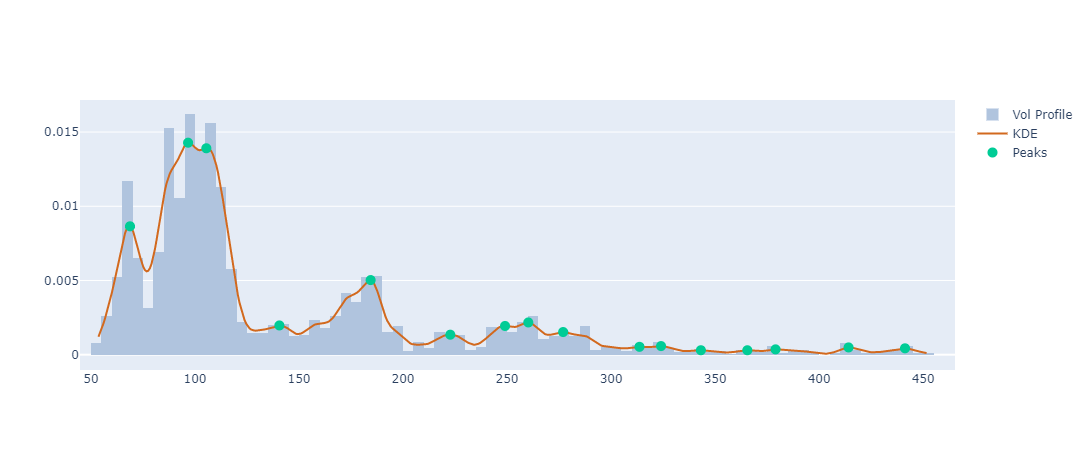

In [109]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [149]:
stock_df_mo = stock.history(period="10y", interval='1mo')
stock_df_mo.index.duplicated().sum()
df_stock_mo = stock_df_mo.loc[~stock_df_mo.index.duplicated(keep='first')]
df_stock_mo.dropna(inplace=True)
df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2011-10-01   92.622001  106.561823   88.455701  103.334175  5.721102e+09   
2011-11-01  100.477035  105.409084   95.676729  102.914238  5.013586e+09   
2011-12-01  102.798977  104.783325   98.830286  103.334175  3.848636e+09   
2012-01-01  105.862177  110.535485  104.760135  108.812004  2.883821e+09   
2012-02-01  109.615701  114.504458  109.483135  113.534996  2.894582e+09   
2012-03-01  113.775331  117.520615  111.330958  116.675438  3.057516e+09   
2012-04-01  117.045273  118.351885  112.983971  116.404449  3.035644e+09   
2012-05-01  116.337845  117.894130  107.815788  109.413673  4.004156e+09   
2012-06-01  107.699266  113.408385  105.810094  113.266907  3.644886e+09   
2012-07-01  114.171693  116.564213  110.925906  115.200653  2.864743e+09   
2012-08-01  116.028802  119.701234  113.418785  118.086708  2.413591e+09   
2012-09-01  117.986310  123.900689  117.225063  120.437393  2.391234e+09   
2012-10-01  121.542918  123.763187  118.069539  118.876915  2.719916e+09   
2012-11-01  119.129192  120.870091  113.284169  119.549698  3.032769e+09   
2012-12-01  120.096365  122.434375  117.354661  119.768372  2.889876e+09   
2013-01-01  122.904592  127.842460  122.582737  126.792206  2.587140e+09   
2013-02-01  127.596856  129.824405  125.970664  128.409958  2.581459e+09   
2013-03-01  127.969553  132.848141  127.393616  132.695679  2.330972e+09   
2013-04-01  133.217811  135.880640  130.631559  135.846603  2.907035e+09   
2013-05-01  135.548808  143.835045  134.502399  139.053864  2.781596e+09   
2013-06-01  139.377202  141.214810  132.486180  136.476166  3.533322e+09   
2013-07-01  137.916674  145.271779  137.027226  144.288254  2.330904e+09   
2013-08-01  145.382967  146.221102  139.447570  139.960709  2.283132e+09   
2013-09-01  141.312012  148.470416  140.003490  143.689590  2.226750e+09   
2013-10-01  144.501728  152.554425  141.399245  151.076233  2.901739e+09   
2013-11-01  151.273884  156.198316  150.191015  155.553757  1.930953e+09   
2013-12-01  155.631099  158.724991  152.391121  158.724991  2.232776e+09   
2014-01-01  158.973223  159.802745  152.838271  153.961563  2.530651e+09   
2014-02-01  153.780080  161.712316  150.099110  160.969208  2.394185e+09   
2014-03-01  159.552173  163.328207  158.774508  161.591400  2.554084e+09   
2014-04-01  162.833968  164.639185  157.357569  163.432816  2.345902e+09   
2014-05-01  163.354702  167.329650  161.436654  167.225494  1.781094e+09   
2014-06-01  167.459871  170.627687  166.609340  169.863937  1.675047e+09   
2014-07-01  171.096433  173.590500  168.279712  168.384354  1.893710e+09   
2014-08-01  167.922222  175.125376  166.169404  175.029449  1.829885e+09   
2014-09-01  175.256138  176.067140  170.965648  171.811539  2.106463e+09   
2014-10-01  172.334243  176.820024  159.385082  176.679840  3.943068e+09   
2014-11-01  176.907708  182.120665  175.278110  181.533661  1.571092e+09   
2014-12-01  180.832740  186.588905  173.350616  180.079269  3.045171e+09   
2015-01-01  181.813165  182.253647  174.915223  175.708084  3.183506e+09   
2015-02-01  176.236646  186.975587  174.307335  185.583664  1.901638e+09   
2015-03-01  185.689403  186.817035  179.822186  181.857208  2.749923e+09   
2015-04-01  182.633562  188.022571  180.969954  184.465302  2.036685e+09   
2015-05-01  185.297130  189.172977  182.961006  186.836853  1.892520e+09   
2015-06-01  187.544757  188.783605  181.651350  182.155746  2.535243e+09   
2015-07-01  184.713487  189.559624  181.494588  187.176575  2.452758e+09   
2015-08-01  187.141033  187.896845  162.190071  175.768158  3.734927e+09   
2015-09-01  171.722268  180.409755  166.218119  170.397369  3.279513e+09   
2015-10-01  171.685458  187.202220  169.039737  185.852539  2.536184e+09   
2015-11-01  186.201166  189.186530  180.713081  186.531876  1.924513e+09   
2015-12-01  187.202248  188.596609  178.612610  182.223648  2.9248

In [150]:
# calculate Bollinger Bands on monthly data
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_mo = df_stock_mo['Close'].ewm(span=length).mean()
df_stock_mo['Moving average monthly'] = m_avg_mo
# standard deviation
m_std_mo = df_stock_mo['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock_mo['upper_BB'] = m_avg_mo + mult * m_std_mo
# lower Bollinger Bands 
df_stock_mo['lower_BB'] = m_avg_mo - mult * m_std_mo
df_stock_mo.head()
df_stock_mo.dropna(inplace=True)

In [151]:
df_stock_mo.isnull().sum()

Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Dividends                 0
Stock Splits              0
Moving average monthly    0
upper_BB                  0
lower_BB                  0
dtype: int64

In [152]:
#Stacked Moving averages monthly 
m_avg_08_mo = df_stock_mo['Close'].ewm(span=8).mean()
m_avg_21_mo = df_stock_mo['Close'].ewm(span=21).mean()
m_avg_34_mo = df_stock_mo['Close'].ewm(span=34).mean()
m_avg_55_mo = df_stock_mo['Close'].ewm(span=55).mean()
m_avg_89_mo = df_stock_mo['Close'].ewm(span=89).mean()

df_stock_mo['m_avg_08'] = m_avg_08_mo
df_stock_mo['m_avg_21'] = m_avg_21_mo
df_stock_mo['m_avg_34'] = m_avg_34_mo
df_stock_mo['m_avg_55'] = m_avg_55_mo
df_stock_mo['m_avg_89'] = m_avg_89_mo

In [153]:
# calculate Keltner Channel monthly
# first we need to calculate True Range
df_stock_mo['tr0'] = abs(df_stock_mo["High"] - df_stock_mo["Low"])
df_stock_mo['tr1'] = abs(df_stock_mo["High"] - df_stock_mo["Close"].shift())
df_stock_mo['tr2'] = abs(df_stock_mo["Low"] - df_stock_mo["Close"].shift())
df_stock_mo['tr'] = df_stock_mo[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma_mo = df_stock_mo['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_mo['upper_KC'] = m_avg_mo + range_ma_mo * mult_KC
# lower Keltner Channel
df_stock_mo['lower_KC'] = m_avg_mo - range_ma_mo * mult_KC
df_stock_mo.tail()

Open        High         Low       Close        Volume  \
Date                                                                       
2021-06-01  419.846992  426.016967  412.027711  425.301605  1.282152e+09   
2021-07-01  427.500420  440.389121  420.622461  437.109650  1.422044e+09   
2021-08-01  438.933810  451.623169  434.707360  450.117981  1.253788e+09   
2021-09-01  451.114762  452.599994  427.490435  432.334930  1.521814e+09   
2021-09-29  435.190002  437.040009  433.850006  436.481903  5.329447e+07   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2021-06-01        0.0             0              351.081706  448.968552   
2021-07-01        0.0             0              359.274904  464.895731   
2021-08-01        0.0             0              367.926684  481.915861   
2021-09-01        0.0             0              374.060840  491.703503   
2021-09-29        0.0             0              380.005736  497.595908   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2021-06-01  253.194860  391.131886  348.660292  323.392036  297.878871   
2021-07-01  253.654077  401.349167  356.701784  329.909426  302.991027   
2021-08-01  253.937508  412.186681  365.194782  336.797660  308.387695   
2021-09-01  256.418177  416.664070  371.298835  342.271298  312.929736   
2021-09-29  262.415564  421.068033  377.224924  347.668115  317.453089   

              m_avg_89        tr0        tr1        tr2         tr  \
Date                                                                 
2021-06-01  276.425334  13.989256   8.683654   5.305602  13.989256   
2021-07-01  280.428825  19.766660  15.087516   4.679144  19.766660   
2021-08-01  284.645318  16.915809  14.513519   2.402290  16.915809   
2021-09-01  288.305547  25.109559   2.482013  22.627546  25.109559   
2021-09-29  291.968458   3.190002   4.705078   1.515076   4.705078   

              upper_KC    lower_KC  
Date                                
2021-06-01  401.083676  301.079735  
2021-07-01  408.325103  310.224705  
2021-08-01  415.593275  320.260093  
2021-09-01  421.959495  326.162186  
2021-09-29  424.405226  335.606246

In [154]:
#ADX Calculations monthly

plus_dm_mo = df_stock_mo["High"].diff()
minus_dm_mo = df_stock_mo["Low"].diff()
plus_dm_mo[plus_dm_mo < 0] = 0
minus_dm_mo[minus_dm_mo > 0] = 0

df_stock_mo['atr'] = df_stock_mo['tr'].ewm(span=14).mean()
df_stock_mo['plus_di'] = 100 * (plus_dm_mo.ewm(alpha = 1/14).mean() / df_stock_mo['atr'])
df_stock_mo['minus_di'] = abs(100 * (minus_dm_mo.ewm(alpha = 1/14).mean() / df_stock_mo['atr']))
dx_mo = (abs(df_stock_mo['plus_di'] - df_stock_mo['minus_di']) / abs(df_stock_mo['plus_di'] + df_stock_mo['minus_di'])) * 100
adx_mo = ((dx_mo.shift(1) * (14 - 1)) + dx_mo) / 14
df_stock_mo['adx'] = adx_mo.ewm(alpha = 1/14).mean()
df_stock_mo.dropna(inplace=True)
df_stock_mo.head()

Open        High         Low       Close        Volume  \
Date                                                                       
2013-07-01  137.916674  145.271779  137.027226  144.288254  2.330904e+09   
2013-08-01  145.382967  146.221102  139.447570  139.960709  2.283132e+09   
2013-09-01  141.312012  148.470416  140.003490  143.689590  2.226750e+09   
2013-10-01  144.501728  152.554425  141.399245  151.076233  2.901739e+09   
2013-11-01  151.273884  156.198316  150.191015  155.553757  1.930953e+09   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2013-07-01        0.0             0              127.002632  149.197588   
2013-08-01        0.0             0              128.373959  150.178309   
2013-09-01        0.0             0              129.977796  152.347735   
2013-10-01        0.0             0              132.166452  156.546700   
2013-11-01        0.0             0              134.572104  161.457119   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2013-07-01  104.807676  140.409256  140.110705  140.044030  140.003631   
2013-08-01  106.569608  140.252048  140.067687  140.021327  139.992308   
2013-09-01  107.607856  141.319882  140.936277  140.843752  140.786503   
2013-10-01  107.786205  144.104386  143.052830  142.809485  142.661070   
2013-11-01  107.687089  147.177895  145.387157  144.966615  144.709778   

              m_avg_89        tr0       tr1       tr2         tr    upper_KC  \
Date                                                                           
2013-07-01  139.978926   8.244554  8.795614  0.551060   8.795614  144.873830   
2013-08-01  139.974217   6.773533  1.932849  4.840684   6.773533  145.005031   
2013-09-01  140.751060   8.466926  8.509707  0.042781   8.509707  146.701999   
2013-10-01  142.570031  11.155179  8.864834  2.290345  11.155179  150.056676   
2013-11-01  144.552207   6.007302  5.122084  0.885218   6.007302  151.365159   

              lower_KC       atr    plus_di   minus_di        adx  
Date                                                               
2013-07-01  109.131435  8.927527  23.563233  10.873920  95.489124  
2013-08-01  111.742886  8.268559  20.438998   7.533682  65.426469  
2013-09-01  113.253593  8.331474  22.153840   5.394973  58.890322  
2013-10-01  114.276229  8.984829  26.289574   3.848630  59.702349  
2013-11-01  117.779048  8.357401  31.315314   3.314218  63.212165

In [155]:
# check for 'squeeze' monthly
df_stock_mo['squeeze_on'] = (df_stock_mo['lower_BB'] > df_stock_mo['lower_KC']) & (df_stock_mo['upper_BB'] < df_stock_mo['upper_KC'])
df_stock_mo['squeeze_off'] = (df_stock_mo['lower_BB'] < df_stock_mo['lower_KC']) & (df_stock_mo['upper_BB'] > df_stock_mo['upper_KC'])
df_stock_mo.head()

Open        High         Low       Close        Volume  \
Date                                                                       
2013-07-01  137.916674  145.271779  137.027226  144.288254  2.330904e+09   
2013-08-01  145.382967  146.221102  139.447570  139.960709  2.283132e+09   
2013-09-01  141.312012  148.470416  140.003490  143.689590  2.226750e+09   
2013-10-01  144.501728  152.554425  141.399245  151.076233  2.901739e+09   
2013-11-01  151.273884  156.198316  150.191015  155.553757  1.930953e+09   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2013-07-01        0.0             0              127.002632  149.197588   
2013-08-01        0.0             0              128.373959  150.178309   
2013-09-01        0.0             0              129.977796  152.347735   
2013-10-01        0.0             0              132.166452  156.546700   
2013-11-01        0.0             0              134.572104  161.457119   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2013-07-01  104.807676  140.409256  140.110705  140.044030  140.003631   
2013-08-01  106.569608  140.252048  140.067687  140.021327  139.992308   
2013-09-01  107.607856  141.319882  140.936277  140.843752  140.786503   
2013-10-01  107.786205  144.104386  143.052830  142.809485  142.661070   
2013-11-01  107.687089  147.177895  145.387157  144.966615  144.709778   

              m_avg_89        tr0       tr1       tr2         tr    upper_KC  \
Date                                                                           
2013-07-01  139.978926   8.244554  8.795614  0.551060   8.795614  144.873830   
2013-08-01  139.974217   6.773533  1.932849  4.840684   6.773533  145.005031   
2013-09-01  140.751060   8.466926  8.509707  0.042781   8.509707  146.701999   
2013-10-01  142.570031  11.155179  8.864834  2.290345  11.155179  150.056676   
2013-11-01  144.552207   6.007302  5.122084  0.885218   6.007302  151.365159   

              lower_KC       atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                            
2013-07-01  109.131435  8.927527  23.563233  10.873920  95.489124       False   
2013-08-01  111.742886  8.268559  20.438998   7.533682  65.426469       False   
2013-09-01  113.253593  8.331474  22.153840   5.394973  58.890322       False   
2013-10-01  114.276229  8.984829  26.289574   3.848630  59.702349       False   
2013-11-01  117.779048  8.357401  31.315314   3.314218  63.212165       False   

            squeeze_off  
Date                     
2013-07-01         True  
2013-08-01         True  
2013-09-01         True  
2013-10-01         True  
2013-11-01         True

In [156]:
# Momentum monthly
highest_mo = df_stock_mo['High'].rolling(window = length_KC).max()
lowest_mo = df_stock_mo['Low'].rolling(window = length_KC).min()
m1_mo = (highest_mo + lowest_mo) / 2
df_stock_mo['value'] = (df_stock_mo['Close'] - (m1_mo + m_avg_mo)/2)
fit_y_mo = np.array(range(0,length_KC))
df_stock_mo['value'] = df_stock_mo['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_mo, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_mo, x, 1)[1], raw=True)

df_stock_mo[['squeeze_on', 'squeeze_off']] = (df_stock_mo[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock_mo["pct_change"] = df_stock_mo['Close'].pct_change()
df_stock_mo.dropna(inplace=True)
"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_mo =  [
    (df_stock_mo['pct_change'] > 0),
    (df_stock_mo['pct_change'] < 0)
]

label = [1, 0]
df_stock_mo['profitable?'] = np.select(conditions_mo, label) 

df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2016-11-01  194.419704  202.536898  190.265252  201.222076  2.073824e+09   
2016-12-01  201.541671  208.490125  200.099021  204.098267  1.821910e+09   
2017-01-01  206.688075  210.977251  205.622683  208.975021  1.482408e+09   
2017-02-01  208.975054  217.957500  208.322962  217.186005  1.365137e+09   
2017-03-01  218.949406  220.722023  212.722313  216.515518  1.921474e+09   
2017-04-01  217.512791  220.953511  214.477935  219.615967  1.549614e+09   
2017-05-01  220.169403  223.305727  217.171453  222.715363  1.492547e+09   
2017-06-01  223.204254  226.008483  221.350142  223.047440  1.572753e+09   
2017-07-01  225.136282  229.882234  222.781836  228.742096  1.055909e+09   
2017-08-01  229.381678  230.725744  224.162976  229.409485  1.557032e+09   
2017-09-01  229.808067  232.959687  227.055041  232.876251  1.286405e+09   
2017-10-01  234.274175  240.236070  234.087855  239.546707  1.320625e+09   
2017-11-01  240.375859  247.837515  238.130833  246.868729  1.365621e+09   
2017-12-01  246.635835  250.212964  242.909655  248.592056  1.715223e+09   
2018-01-01  250.780240  268.373441  250.368263  263.944702  1.985507e+09   
2018-02-01  263.167613  265.030853  236.810583  254.347595  2.923722e+09   
2018-03-01  254.122876  262.549632  241.407821  246.388977  2.323562e+09   
2018-04-01  246.811751  255.037243  239.404117  248.654282  1.998466e+09   
2018-05-01  248.052633  257.810421  243.521555  254.698837  1.606397e+09   
2018-06-01  256.080685  262.726889  252.395653  255.018417  1.599001e+09   
2018-07-01  254.492256  268.524207  254.237283  265.653595  1.266892e+09   
2018-08-01  265.870751  275.483489  263.604491  274.133179  1.308444e+09   
2018-09-01  273.689417  277.560961  270.733823  274.520386  1.228103e+09   
2018-10-01  277.081447  278.124860  246.481186  256.706573  3.024346e+09   
2018-11-01  257.626729  266.751795  249.535582  261.468353  2.021061e+09   
2018-12-01  265.860141  265.973963  221.733500  237.062103  3.102780e+09   
2019-01-01  234.687332  258.053029  232.483383  257.537811  2.048692e+09   
2019-02-01  257.747712  268.395373  255.534214  265.886108  1.371716e+09   
2019-03-01  267.565334  272.087717  259.913533  269.511688  1.678081e+09   
2019-04-01  272.826232  282.169596  272.538726  281.757507  1.209205e+09   
2019-05-01  282.428313  282.648732  263.760742  263.789490  1.845593e+09   
2019-06-01  263.827870  283.952041  261.700457  280.780090  1.340436e+09   
2019-07-01  285.689314  291.033728  283.426365  286.411530  1.110102e+09   
2019-08-01  286.575268  289.724119  271.283546  281.616058  2.034005e+09   
2019-09-01  279.805701  291.418930  278.553842  285.776001  1.303830e+09   
2019-10-01  288.034094  294.622095  275.535284  293.441864  1.386748e+09   
2019-11-01  294.980080  305.195838  294.805925  304.063965  1.037124e+09   
2019-12-01  304.334830  313.244590  297.118023  311.367828  1.285176e+09   
2020-01-01  314.531911  323.679919  311.440427  312.772308  1.392004e+09   
2020-02-01  314.347225  329.639248  277.589942  288.011475  2.110215e+09   
2020-03-01  289.907148  305.101978  212.183140  250.573654  5.926018e+09   
2020-04-01  242.493300  288.355620  238.503570  284.052979  2.819312e+09   
2020-05-01  278.997273  300.050902  266.949856  297.586670  1.910460e+09   
2020-06-01  296.902208  316.254350  290.174428  301.537323  2.358674e+09   
2020-07-01  304.052643  321.397898  303.561555  320.700531  1.505145e+09   
2020-08-01  322.468516  345.038935  321.889035  343.084412  1.045563e+09   
2020-09-01  343.968353  352.356157  314.100333  328.921417  1.814713e+09   
2020-10-01  332.999200  349.102349  318.118817  322.004089  1.629016e+09   
2020-11-01  325.613220  359.318420  322.694315  357.030640  1.535244e+09   
2020-12-01  360.491898  373.202829  357.001064  368.686462  1.344542e+09   
2021-01-01  371.674214  382.112117  361.285844  366.484985  1.4022

In [157]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_mo = (df_stock_mo['squeeze_off'].iloc[-2] == 0) | (df_stock_mo['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_mo = df_stock_mo['value'][-1] > 0

enter_long_mo = long_cond1_mo and long_cond2_mo
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_mo = (df_stock_mo['squeeze_off'][-2] == 0) | (df_stock_mo['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_mo = df_stock_mo['value'][-1] < 0
enter_short_mo = short_cond1_mo and short_cond2_mo

In [158]:
ohcl_mo = df_stock_mo[['Open', 'High', 'Close', 'Low']]
ohcl_mo.head()

Open        High       Close         Low
Date                                                      
2016-11-01  194.419704  202.536898  201.222076  190.265252
2016-12-01  201.541671  208.490125  204.098267  200.099021
2017-01-01  206.688075  210.977251  208.975021  205.622683
2017-02-01  208.975054  217.957500  217.186005  208.322962
2017-03-01  218.949406  220.722023  216.515518  212.722313

In [159]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock_mo['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock_mo['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock_mo['value'][ind-1]:
      color='red'
  colors.append(color)

In [160]:
len(colors)

60

In [161]:
df_stock_mo['colors'] = colors

In [162]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
        mpf.make_addplot(df_stock_mo[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock_mo[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock_mo[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle', 
              addplot=apds,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [163]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs_mo = stochastics( df_stock_mo, 'Low', 'High', 'Close', 14, 3 )
slow_k_mo = stochs_mo['k_slow'].values
fast_k_mo = stochs_mo['k_fast'].values
df_stock_mo["slow_K"] = slow_k_mo
df_stock_mo['fast_K'] = fast_k_mo
df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2016-11-01  194.419704  202.536898  190.265252  201.222076  2.073824e+09   
2016-12-01  201.541671  208.490125  200.099021  204.098267  1.821910e+09   
2017-01-01  206.688075  210.977251  205.622683  208.975021  1.482408e+09   
2017-02-01  208.975054  217.957500  208.322962  217.186005  1.365137e+09   
2017-03-01  218.949406  220.722023  212.722313  216.515518  1.921474e+09   
2017-04-01  217.512791  220.953511  214.477935  219.615967  1.549614e+09   
2017-05-01  220.169403  223.305727  217.171453  222.715363  1.492547e+09   
2017-06-01  223.204254  226.008483  221.350142  223.047440  1.572753e+09   
2017-07-01  225.136282  229.882234  222.781836  228.742096  1.055909e+09   
2017-08-01  229.381678  230.725744  224.162976  229.409485  1.557032e+09   
2017-09-01  229.808067  232.959687  227.055041  232.876251  1.286405e+09   
2017-10-01  234.274175  240.236070  234.087855  239.546707  1.320625e+09   
2017-11-01  240.375859  247.837515  238.130833  246.868729  1.365621e+09   
2017-12-01  246.635835  250.212964  242.909655  248.592056  1.715223e+09   
2018-01-01  250.780240  268.373441  250.368263  263.944702  1.985507e+09   
2018-02-01  263.167613  265.030853  236.810583  254.347595  2.923722e+09   
2018-03-01  254.122876  262.549632  241.407821  246.388977  2.323562e+09   
2018-04-01  246.811751  255.037243  239.404117  248.654282  1.998466e+09   
2018-05-01  248.052633  257.810421  243.521555  254.698837  1.606397e+09   
2018-06-01  256.080685  262.726889  252.395653  255.018417  1.599001e+09   
2018-07-01  254.492256  268.524207  254.237283  265.653595  1.266892e+09   
2018-08-01  265.870751  275.483489  263.604491  274.133179  1.308444e+09   
2018-09-01  273.689417  277.560961  270.733823  274.520386  1.228103e+09   
2018-10-01  277.081447  278.124860  246.481186  256.706573  3.024346e+09   
2018-11-01  257.626729  266.751795  249.535582  261.468353  2.021061e+09   
2018-12-01  265.860141  265.973963  221.733500  237.062103  3.102780e+09   
2019-01-01  234.687332  258.053029  232.483383  257.537811  2.048692e+09   
2019-02-01  257.747712  268.395373  255.534214  265.886108  1.371716e+09   
2019-03-01  267.565334  272.087717  259.913533  269.511688  1.678081e+09   
2019-04-01  272.826232  282.169596  272.538726  281.757507  1.209205e+09   
2019-05-01  282.428313  282.648732  263.760742  263.789490  1.845593e+09   
2019-06-01  263.827870  283.952041  261.700457  280.780090  1.340436e+09   
2019-07-01  285.689314  291.033728  283.426365  286.411530  1.110102e+09   
2019-08-01  286.575268  289.724119  271.283546  281.616058  2.034005e+09   
2019-09-01  279.805701  291.418930  278.553842  285.776001  1.303830e+09   
2019-10-01  288.034094  294.622095  275.535284  293.441864  1.386748e+09   
2019-11-01  294.980080  305.195838  294.805925  304.063965  1.037124e+09   
2019-12-01  304.334830  313.244590  297.118023  311.367828  1.285176e+09   
2020-01-01  314.531911  323.679919  311.440427  312.772308  1.392004e+09   
2020-02-01  314.347225  329.639248  277.589942  288.011475  2.110215e+09   
2020-03-01  289.907148  305.101978  212.183140  250.573654  5.926018e+09   
2020-04-01  242.493300  288.355620  238.503570  284.052979  2.819312e+09   
2020-05-01  278.997273  300.050902  266.949856  297.586670  1.910460e+09   
2020-06-01  296.902208  316.254350  290.174428  301.537323  2.358674e+09   
2020-07-01  304.052643  321.397898  303.561555  320.700531  1.505145e+09   
2020-08-01  322.468516  345.038935  321.889035  343.084412  1.045563e+09   
2020-09-01  343.968353  352.356157  314.100333  328.921417  1.814713e+09   
2020-10-01  332.999200  349.102349  318.118817  322.004089  1.629016e+09   
2020-11-01  325.613220  359.318420  322.694315  357.030640  1.535244e+09   
2020-12-01  360.491898  373.202829  357.001064  368.686462  1.344542e+09   
2021-01-01  371.674214  382.112117  361.285844  366.484985  1.4022

In [164]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock_mo['rsi_14'] = get_rsi(df_stock_mo['Close'], 14)
df_stock_mo = df_stock_mo.dropna()
df_stock_mo['Overbought'] = 70
df_stock_mo['Oversold'] = 30
df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2018-02-01  263.167613  265.030853  236.810583  254.347595  2.923722e+09   
2018-03-01  254.122876  262.549632  241.407821  246.388977  2.323562e+09   
2018-04-01  246.811751  255.037243  239.404117  248.654282  1.998466e+09   
2018-05-01  248.052633  257.810421  243.521555  254.698837  1.606397e+09   
2018-06-01  256.080685  262.726889  252.395653  255.018417  1.599001e+09   
2018-07-01  254.492256  268.524207  254.237283  265.653595  1.266892e+09   
2018-08-01  265.870751  275.483489  263.604491  274.133179  1.308444e+09   
2018-09-01  273.689417  277.560961  270.733823  274.520386  1.228103e+09   
2018-10-01  277.081447  278.124860  246.481186  256.706573  3.024346e+09   
2018-11-01  257.626729  266.751795  249.535582  261.468353  2.021061e+09   
2018-12-01  265.860141  265.973963  221.733500  237.062103  3.102780e+09   
2019-01-01  234.687332  258.053029  232.483383  257.537811  2.048692e+09   
2019-02-01  257.747712  268.395373  255.534214  265.886108  1.371716e+09   
2019-03-01  267.565334  272.087717  259.913533  269.511688  1.678081e+09   
2019-04-01  272.826232  282.169596  272.538726  281.757507  1.209205e+09   
2019-05-01  282.428313  282.648732  263.760742  263.789490  1.845593e+09   
2019-06-01  263.827870  283.952041  261.700457  280.780090  1.340436e+09   
2019-07-01  285.689314  291.033728  283.426365  286.411530  1.110102e+09   
2019-08-01  286.575268  289.724119  271.283546  281.616058  2.034005e+09   
2019-09-01  279.805701  291.418930  278.553842  285.776001  1.303830e+09   
2019-10-01  288.034094  294.622095  275.535284  293.441864  1.386748e+09   
2019-11-01  294.980080  305.195838  294.805925  304.063965  1.037124e+09   
2019-12-01  304.334830  313.244590  297.118023  311.367828  1.285176e+09   
2020-01-01  314.531911  323.679919  311.440427  312.772308  1.392004e+09   
2020-02-01  314.347225  329.639248  277.589942  288.011475  2.110215e+09   
2020-03-01  289.907148  305.101978  212.183140  250.573654  5.926018e+09   
2020-04-01  242.493300  288.355620  238.503570  284.052979  2.819312e+09   
2020-05-01  278.997273  300.050902  266.949856  297.586670  1.910460e+09   
2020-06-01  296.902208  316.254350  290.174428  301.537323  2.358674e+09   
2020-07-01  304.052643  321.397898  303.561555  320.700531  1.505145e+09   
2020-08-01  322.468516  345.038935  321.889035  343.084412  1.045563e+09   
2020-09-01  343.968353  352.356157  314.100333  328.921417  1.814713e+09   
2020-10-01  332.999200  349.102349  318.118817  322.004089  1.629016e+09   
2020-11-01  325.613220  359.318420  322.694315  357.030640  1.535244e+09   
2020-12-01  360.491898  373.202829  357.001064  368.686462  1.344542e+09   
2021-01-01  371.674214  382.112117  361.285844  366.484985  1.402265e+09   
2021-02-01  370.099603  390.351506  366.791963  376.675262  1.307806e+09   
2021-03-01  381.854623  394.263238  368.277446  392.490570  2.401716e+09   
2021-04-01  395.832728  418.008906  395.614144  414.610931  1.462107e+09   
2021-05-01  416.727228  420.095398  401.396665  417.333313  1.547236e+09   
2021-06-01  419.846992  426.016967  412.027711  425.301605  1.282152e+09   
2021-07-01  427.500420  440.389121  420.622461  437.109650  1.422044e+09   
2021-08-01  438.933810  451.623169  434.707360  450.117981  1.253788e+09   
2021-09-01  451.114762  452.599994  427.490435  432.334930  1.521814e+09   
2021-09-29  435.190002  437.040009  433.850006  436.481903  5.329447e+07   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2018-02-01        0.0             0              226.044718  267.804268   
2018-03-01        0.0             0              227.983055  269.354285   
2018-04-01        0.0             0              229.952469  270.583535   
2018-05-01        0.0             0              232.310051  272.02019

In [165]:

apds2 = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
         mpf.make_addplot(df_stock_mo['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock_mo['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock_mo['slow_K'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_mo['fast_K'], panel=2, color = 'blue'),
         mpf.make_addplot(df_stock_mo['Overbought'], panel=2, color = 'green'),
         mpf.make_addplot(df_stock_mo['Oversold'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_mo['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock_mo['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock_mo['rsi_14'], panel=3, color='purple')]
fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle', 
              addplot=apds2,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [166]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker_mo(index):
    if (df_stock_mo['m_avg_08'][index] > df_stock_mo['m_avg_21'][index] > df_stock_mo['m_avg_34'][index] > df_stock_mo['m_avg_55'][index] > df_stock_mo['m_avg_89'][index]):
        print('Positive momentum')
    elif (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_21'][index] < df_stock_mo['m_avg_34'][index] < df_stock_mo['m_avg_55'][index] < df_stock_mo['m_avg_89'][index]):
        print('Negative momentum')
    else:
        print('neutral')

In [167]:
df_stock_mo['ADX_trend'] = 20

def ADX_trend_flag_mo(index):
    if (df_stock_mo['adx'][index] > df_stock_mo['ADX_trend'][index]) and (df_stock_mo['plus_di'][index] > df_stock_mo['minus_di'][index]):
        print('positive trend')
    elif (df_stock_mo['adx'][index] > df_stock_mo['ADX_trend'][index]) and (df_stock_mo['plus_di'][index] < df_stock_mo['minus_di'][index]):
        print('negative trend')
    elif (df_stock_mo['adx'][index] < df_stock_mo['ADX_trend'][index]):
        print('neutral or sideways trend')

In [168]:
def warning_mo(index):
    if (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_21'][index]):
        print('Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.  This is especially bad with this monthly chart')
    if (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_34'][index]):
        print('As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema')
    elif (df_stock_mo['m_avg_08'][index] > df_stock_mo['m_avg_21'][index]):
        print('Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger')

In [169]:
def squeeze_momentum_mo(index):
    if (df_stock_mo['squeeze_on'][index] == 1.0):
        print('squeeze is on')
    else:
        print('squeeze is off')
    
    if (df_stock_mo['colors'][index] == 'cyan'):
        print('stock is in a mark up mode')
    elif (df_stock_mo['colors'][index] == 'blue'):
        print('stock is in a distribution mode')
    elif (df_stock_mo['colors'][index] == 'yellow'):
        print('stock is in an accumulation mode')
    elif (df_stock_mo['colors'][index] == 'red'):
        print('stock is in a mark down mode')

In [170]:
momentum_checker_mo(-1)

Positive momentum


In [171]:
ADX_trend_flag_mo(-1)

positive trend


In [172]:
warning_mo(-1)

Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger


In [173]:
squeeze_momentum_mo(-1)

squeeze is off
stock is in a mark up mode


In [174]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
df_stock_mo['value_threshold'] = abs(df_stock_mo['value'].max()*.15)
df_stock_mo['squeeze_threshold'] = 1.0
df_stock_mo["squeeze_entry"] = np.logical_and(np.greater(df_stock_mo["value"], df_stock_mo['value_threshold']), 
                                           np.equal(df_stock_mo['squeeze_on'], df_stock_mo['squeeze_threshold']))
df_stock_mo['squeeze_entry'] = df_stock_mo['squeeze_entry'].astype(float)
df_stock_mo['Entry/Exit'] = df_stock_mo['squeeze_entry'].diff()
df_stock_mo.dropna(inplace=True)

In [175]:
def implement_bb_strategy_mo(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

In [176]:
buy_price_mo, sell_price_mo, squeeze_signal_mo = implement_bb_strategy_mo(df_stock_mo["Close"], df_stock_mo['squeeze_on'], df_stock_mo['value'], 
                                                              df_stock_mo['upper_KC'], df_stock_mo['value_threshold'], df_stock_mo['colors'], 1.50)

In [177]:
df_stock_mo['buy_price'] =  buy_price_mo
df_stock_mo['sell_price'] = sell_price_mo
df_stock_mo['squeeze_signal'] = squeeze_signal_mo
df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2018-03-01  254.122876  262.549632  241.407821  246.388977  2.323562e+09   
2018-04-01  246.811751  255.037243  239.404117  248.654282  1.998466e+09   
2018-05-01  248.052633  257.810421  243.521555  254.698837  1.606397e+09   
2018-06-01  256.080685  262.726889  252.395653  255.018417  1.599001e+09   
2018-07-01  254.492256  268.524207  254.237283  265.653595  1.266892e+09   
2018-08-01  265.870751  275.483489  263.604491  274.133179  1.308444e+09   
2018-09-01  273.689417  277.560961  270.733823  274.520386  1.228103e+09   
2018-10-01  277.081447  278.124860  246.481186  256.706573  3.024346e+09   
2018-11-01  257.626729  266.751795  249.535582  261.468353  2.021061e+09   
2018-12-01  265.860141  265.973963  221.733500  237.062103  3.102780e+09   
2019-01-01  234.687332  258.053029  232.483383  257.537811  2.048692e+09   
2019-02-01  257.747712  268.395373  255.534214  265.886108  1.371716e+09   
2019-03-01  267.565334  272.087717  259.913533  269.511688  1.678081e+09   
2019-04-01  272.826232  282.169596  272.538726  281.757507  1.209205e+09   
2019-05-01  282.428313  282.648732  263.760742  263.789490  1.845593e+09   
2019-06-01  263.827870  283.952041  261.700457  280.780090  1.340436e+09   
2019-07-01  285.689314  291.033728  283.426365  286.411530  1.110102e+09   
2019-08-01  286.575268  289.724119  271.283546  281.616058  2.034005e+09   
2019-09-01  279.805701  291.418930  278.553842  285.776001  1.303830e+09   
2019-10-01  288.034094  294.622095  275.535284  293.441864  1.386748e+09   
2019-11-01  294.980080  305.195838  294.805925  304.063965  1.037124e+09   
2019-12-01  304.334830  313.244590  297.118023  311.367828  1.285176e+09   
2020-01-01  314.531911  323.679919  311.440427  312.772308  1.392004e+09   
2020-02-01  314.347225  329.639248  277.589942  288.011475  2.110215e+09   
2020-03-01  289.907148  305.101978  212.183140  250.573654  5.926018e+09   
2020-04-01  242.493300  288.355620  238.503570  284.052979  2.819312e+09   
2020-05-01  278.997273  300.050902  266.949856  297.586670  1.910460e+09   
2020-06-01  296.902208  316.254350  290.174428  301.537323  2.358674e+09   
2020-07-01  304.052643  321.397898  303.561555  320.700531  1.505145e+09   
2020-08-01  322.468516  345.038935  321.889035  343.084412  1.045563e+09   
2020-09-01  343.968353  352.356157  314.100333  328.921417  1.814713e+09   
2020-10-01  332.999200  349.102349  318.118817  322.004089  1.629016e+09   
2020-11-01  325.613220  359.318420  322.694315  357.030640  1.535244e+09   
2020-12-01  360.491898  373.202829  357.001064  368.686462  1.344542e+09   
2021-01-01  371.674214  382.112117  361.285844  366.484985  1.402265e+09   
2021-02-01  370.099603  390.351506  366.791963  376.675262  1.307806e+09   
2021-03-01  381.854623  394.263238  368.277446  392.490570  2.401716e+09   
2021-04-01  395.832728  418.008906  395.614144  414.610931  1.462107e+09   
2021-05-01  416.727228  420.095398  401.396665  417.333313  1.547236e+09   
2021-06-01  419.846992  426.016967  412.027711  425.301605  1.282152e+09   
2021-07-01  427.500420  440.389121  420.622461  437.109650  1.422044e+09   
2021-08-01  438.933810  451.623169  434.707360  450.117981  1.253788e+09   
2021-09-01  451.114762  452.599994  427.490435  432.334930  1.521814e+09   
2021-09-29  435.190002  437.040009  433.850006  436.481903  5.329447e+07   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2018-03-01        0.0             0              227.983055  269.354285   
2018-04-01        0.0             0              229.952469  270.583535   
2018-05-01        0.0             0              232.310051  272.020198   
2018-06-01        0.0             0              234.473405  271.834908   
2018-07-01        0.0             0              237.443757  274.331679

In [178]:
# Visualize exit position relative to close price
exit = df_stock_mo[df_stock_mo['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_mo[df_stock_mo['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_mo[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [181]:
position = []
#df_stock_wk = df_stock_wk.loc[~df_stock_wk.index.duplicated(keep='first')]
for i in range(len(squeeze_signal_mo)):
    if df_stock_mo['squeeze_signal'][i] < 1.0:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_mo['Close'])):
    if df_stock_mo['squeeze_signal'][i] == 1.0:
        position[i] = 1.0
    elif df_stock_mo['squeeze_signal'][i] == -1.0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_mo['Close']
squeeze_signal_mo = pd.DataFrame(squeeze_signal_mo).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_mo.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_mo.index)

frames = [close_price, squeeze_signal_mo, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date       Close  squeeze_signal  squeeze_position
0  2018-03-01  246.388977             0.0               0.0
1  2018-04-01  248.654282             0.0               0.0
2  2018-05-01  254.698837             0.0               0.0
3  2018-06-01  255.018417             0.0               0.0
4  2018-07-01  265.653595             0.0               0.0
5  2018-08-01  274.133179             0.0               0.0
6  2018-09-01  274.520386             0.0               0.0
7  2018-10-01  256.706573             0.0               0.0
8  2018-11-01  261.468353             0.0               0.0
9  2018-12-01  237.062103             0.0               0.0
10 2019-01-01  257.537811             0.0               0.0
11 2019-02-01  265.886108             0.0               0.0
12 2019-03-01  269.511688             0.0               0.0
13 2019-04-01  281.757507             1.0               1.0
14 2019-05-01  263.789490             0.0               1.0
15 2019-06-01  280.780090             0.0               1.0
16 2019-07-01  286.411530             0.0               1.0
17 2019-08-01  281.616058             0.0               1.0
18 2019-09-01  285.776001             0.0               1.0
19 2019-10-01  293.441864             0.0               1.0
20 2019-11-01  304.063965             0.0               1.0
21 2019-12-01  311.367828             0.0               1.0
22 2020-01-01  312.772308             0.0               1.0
23 2020-02-01  288.011475             0.0               1.0
24 2020-03-01  250.573654             0.0               1.0
25 2020-04-01  284.052979             0.0               1.0
26 2020-05-01  297.586670             0.0               1.0
27 2020-06-01  301.537323             0.0               1.0
28 2020-07-01  320.700531             0.0               1.0
29 2020-08-01  343.084412             0.0               1.0
30 2020-09-01  328.921417             0.0               1.0
31 2020-10-01  322.004089             0.0               1.0
32 2020-11-01  357.030640             0.0               1.0
33 2020-12-01  368.686462             0.0               1.0
34 2021-01-01  366.484985             0.0               1.0
35 2021-02-01  376.675262             0.0               1.0
36 2021-03-01  392.490570             0.0               1.0
37 2021-04-01  414.610931             0.0               1.0
38 2021-05-01  417.333313             0.0               1.0
39 2021-06-01  425.301605            -1.0               0.0
40 2021-07-01  437.109650             0.0               0.0
41 2021-08-01  450.117981             0.0               0.0
42 2021-09-01  432.334930             0.0               0.0
43 2021-09-29  436.481903             0.0               0.0

In [182]:
stock_ret = pd.DataFrame(np.diff(df_stock_mo['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_mo['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_mo['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in spy is 49101.1
Profit percentage of the Squeeze strategy : 49%
49101.095138549805


In [ ]:
px.histogram(df_stock_wk, x='Volume', y='Close', nbins=150, orientation='h').show()

In [ ]:
import panel as pn
from panel.interact import interact

pn.extension()

def daily_figure():
# add 2 subplots: 1. bars, 2. crosses
    apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock['Moving average'], color = 'black'),
            mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
            mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
            mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(ohcl, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    
    return pn.pane.Matplotlib(fig, tight=True)

def daily_figure_2():
    apds2 = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock['Moving average'], color = 'black'),
             mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)


    

In [ ]:
kde_factor = 0.05
num_samples = 500
close = df_stock_wk['Close']
volume = df_stock_wk['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

In [ ]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [ ]:
 # Create our features
X = df_stock.copy()
X.drop(columns=['profitable?',"squeeze_off","tr0","tr1","tr2","tr","Dividends","Stock Splits",'plus_di','minus_di'], axis=1, inplace=True)

# Create our target
y = df_stock[['profitable?']]

y.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, stratify=y)
X_train.shape

In [ ]:
y_train

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [ ]:
# Scale the training and testing data
X_trained_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Resample the training data with the BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1)
rf_model = rf_model.fit(X_trained_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm

In [ ]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

In [ ]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
listed = sorted(zip(rf_model.feature_importances_, X.columns), reverse = True)
listed

In [ ]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
eec_model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
eec_model = eec_model.fit(X_trained_scaled, y_train)
predictions = eec_model.predict(X_test_scaled)

In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm

In [ ]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

In [ ]:
#Add other classifier models

# HW LSTM Model

In [ ]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [ ]:
df = df_stock[['Volume','squeeze_on', 'adx', 'Close']]
df.head()

In [ ]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 3
target_column = 3
X, y = window_data(df, window_size, feature_column, target_column)

In [ ]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 5
dropout_fraction = 0

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

In [ ]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_profit = y_test_scaler.inverse_transform(predicted)
real_profit = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_profit.ravel(),
    "Predicted": predicted_profit.ravel()
}, index = df_stock.index[-len(real_profit): ]) 
stocks.head()

In [ ]:
# Plot the real vs predicted values as a line chart
stocks.plot(figsize = (10,5), title="Actual Vs. Predicted TDOC Closing Prices")

Linear Regression Model

In [ ]:
df_stock['Lagged_Close'] = df_stock['Close'].shift()
df_stock = df_stock.dropna()
df_stock.head()

In [ ]:
# to_period("w") splits the series into weekly increments
df_stock.index.to_period("w")

In [ ]:
# construct a list of all Pandas weekly periods that are in the dataset:
weeks = df_stock.index.to_period("w").unique()
weeks

In [ ]:
# Training Window (26 weeks)
training_window = 26

In [ ]:
# Beginning of training window
start_of_training_period = weeks[0].start_time.strftime(format="%Y-%m-%d")
start_of_training_period

In [ ]:
# End of training window
end_of_training_period = weeks[training_window + 0].end_time.strftime(format="%Y-%m-%d")
end_of_training_period

In [ ]:
# The week of the first test window
test_week = weeks[training_window + 0 + 1]
test_week

In [ ]:
# The first day of the test week
start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
start_of_test_week

In [ ]:
# The last day of the test week
end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
end_of_test_week

In [ ]:
# Training data with just one window
train = df_stock[start_of_training_period:end_of_training_period]
train

In [ ]:
# Testing data with just one window
test = df_stock[start_of_test_week:end_of_test_week]
test

In [ ]:
# Set the training window as 26 weeks
# Total timeframe is 287 weeks
training_window = 26
timeframe = len(weeks) - training_window - 1
timeframe

In [ ]:
# Construct an empty placeholder DataFrame, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_predictions

In [ ]:
# Construct a separate empty DataFrame for actual data
all_actuals = pd.DataFrame(columns=["Actual Prices"])
all_actuals

In [ ]:
from sklearn.linear_model import LinearRegression
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window + i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window+i+1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = df_stock[start_of_training_period:end_of_training_period]
    test = df_stock[start_of_test_week:end_of_test_week]
    
    # Create new DataFrames:
    X_train = train["Lagged_Close"].to_frame()
    y_train = train["Close"]
    X_test = test["Lagged_Close"].to_frame()
    y_test = test["Close"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # Create a temporary DataFrame to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    # Create a temporary DataFrame of the actual "y"s in the test DataFrame, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Prices"]  
    # Append these two DataFrames (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)

In [ ]:
# Once the loop is done, concatenate (combine) the two DataFrames to a final "Results" DataFrame:    
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

In [ ]:
# Plot the first 20 predictions vs the true values
Results[:20].plot()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(
    Results["Actual Prices"],
    Results["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

# Multifeature LSTM Model

In [ ]:
#multi feature LSTM
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# load dataset
values = df_stock.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,10,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 252
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0],1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
#model.add(Dropout(0.3))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
number_units = 50
dropout_fraction = 0.2
# design network
model = Sequential()
model.add(LSTM(units=number_units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
# plot history
fig = pyplot.figure()
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#self.synaptic_weights = self.synaptic_weights + adjustment
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat.reshape(764,16))
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y.reshape(764,16))
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [166]:
screened_list = []
stock_list = ['AAPL','TSLA','MSFT','AMZN']

for stock_code in stock_list:
    df = yf.download(stock_code, start='2020-01-01', threads= False)
    if enter_long | enter_short:
        screened_list.append(stock_code)
    
if screened_list:
  print(screened_list)
else:
  print('No stock fits the indicator entry requirement')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
['AAPL', 'TSLA', 'MSFT', 'AMZN']


In [167]:
help(mpf.plot)

Help on function plot in module mplfinance.plotting:

plot(data, **kwargs)
    Given a Pandas DataFrame containing columns Open,High,Low,Close and optionally Volume
    with a DatetimeIndex, plot the data.
    Available plots include ohlc bars, candlestick, and line plots.
    Also provide visually analysis in the form of common technical studies, such as:
    moving averages, renko, etc.
    Also provide ability to plot trading signals, and/or addtional user-defined data.



In [168]:
tickers = ['NFLX', 'AAPL', 'FB', 'GOOG', 'AMZN', 'PYPL', 'TSLA', 'SQ']

ticker_dict_1mo = {}
ticker_dict_1wk = {}
ticker_dict_1d = {}
for stock in tickers:
    ticker_dict_1mo[stock] = yf.Ticker(stock).history(period="10y", interval='1mo')
    ticker_dict_1mo[stock]["ticker"] = stock
    ticker_dict_1wk[stock] = yf.Ticker(stock).history(period="10y", interval='1wk')
    ticker_dict_1wk[stock]['ticker'] = stock
    ticker_dict_1d[stock] = yf.Ticker(stock).history(period="10y", interval='1d')
    ticker_dict_1d[stock]['ticker'] = stock
    
ticker_dict_1mo['AAPL']

daily_data = pd.concat(ticker_dict_1d.values())
weekly_data = pd.concat(ticker_dict_1wk.values())
monthly_data = pd.concat(ticker_dict_1mo.values())
daily_data

Open        High         Low       Close    Volume  \
Date                                                                   
2011-09-30   15.602857   16.535713   15.375714   16.181429  76881700   
2011-10-03   16.448570   17.134287   16.088572   16.178572  59146500   
2011-10-04   16.382856   16.714287   15.714286   16.414286  50512000   
2011-10-05   16.512857   17.122856   16.000000   17.108570  52418800   
2011-10-06   17.100000   17.750000   16.925714   17.605715  40497100   
...                ...         ...         ...         ...       ...   
2021-09-23  263.489990  268.170013  262.700012  266.720001   7837900   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   

            Dividends  Stock Splits ticker  
Date                                        
2011-09-30        0.0           0.0   NFLX  
2011-10-03        0.0           0.0   NFLX  
2011-10-04        0.0           0.0   NFLX  
2011-10-05        0.0           0.0   NFLX  
2011-10-06        0.0           0.0   NFLX  
...               ...           ...    ...  
2021-09-23        0.0           0.0     SQ  
2021-09-24        0.0           0.0     SQ  
2021-09-27        0.0           0.0     SQ  
2021-09-28        0.0           0.0     SQ  
2021-09-29        0.0           0.0     SQ  

[17984 rows x 8 columns]

In [169]:
# calculate Bollinger Bands
m_avg_mo = {}
m_avg_wk = {}
m_avg_d = {}
m_std_mo = {}
m_std_wk = {}
m_std_d = {}

for stock in tickers:
    # moving average
    m_avg_mo[stock] = ticker_dict_1mo[stock]['Close'].rolling(window=length).mean()
    m_avg_wk[stock] = ticker_dict_1wk[stock]['Close'].rolling(window=length).mean()
    m_avg_d[stock] = ticker_dict_1d[stock]['Close'].rolling(window=length).mean()
    # standard deviation
    m_std_mo[stock] = ticker_dict_1mo[stock]['Close'].rolling(window=length).std(ddof=0)
    m_std_wk[stock] = ticker_dict_1wk[stock]['Close'].rolling(window=length).std(ddof=0)
    m_std_d[stock] = ticker_dict_1d[stock]['Close'].rolling(window=length).std(ddof=0)
    # upper Bollinger Bands
    ticker_dict_1mo[stock]['upper_BB'] = m_avg_mo[stock] + mult * m_std_mo[stock]
    ticker_dict_1wk[stock]['upper_BB'] = m_avg_wk[stock] + mult * m_std_wk[stock]
    ticker_dict_1d[stock]['upper_BB'] = m_avg_d[stock] + mult * m_std_d[stock]
# lower Bollinger Bands 
    ticker_dict_1mo[stock]['lower_BB'] = m_avg_mo[stock] - mult * m_std_mo[stock]
    ticker_dict_1wk[stock]['lower_BB'] = m_avg_wk[stock] - mult * m_std_wk[stock]
    ticker_dict_1d[stock]['lower_BB'] = m_avg_d[stock] - mult * m_std_d[stock]
    
ticker_dict_1d[stock]

Open        High         Low       Close    Volume  \
Date                                                                   
2015-11-19   11.200000   14.780000    9.000000   13.070000  47466100   
2015-11-20   13.920000   14.050000   12.500000   12.850000  16550300   
2015-11-23   13.000000   13.150000   12.100000   12.120000   5172200   
2015-11-24   12.000000   12.230000   11.520000   12.020000   4714700   
2015-11-25   12.120000   12.400000   11.850000   11.900000   3583400   
...                ...         ...         ...         ...       ...   
2021-09-23  263.489990  268.170013  262.700012  266.720001   7837900   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   

            Dividends  Stock Splits ticker    upper_BB    lower_BB  
Date                                                                
2015-11-19          0             0     SQ         NaN         NaN  
2015-11-20          0             0     SQ         NaN         NaN  
2015-11-23          0             0     SQ         NaN         NaN  
2015-11-24          0             0     SQ         NaN         NaN  
2015-11-25          0             0     SQ         NaN         NaN  
...               ...           ...    ...         ...         ...  
2021-09-23          0             0     SQ  275.908602  241.769398  
2021-09-24          0             0     SQ  275.942124  241.772876  
2021-09-27          0             0     SQ  274.923366  241.801631  
2021-09-28          0             0     SQ  273.575603  240.227392  
2021-09-29          0             0     SQ  273.462043  237.137951  

[1475 rows x 10 columns]

In [170]:
# calculate Keltner Channel
range_ma_mo = {}
range_ma_wk = {}
range_ma_d = {}

for stock in tickers:
    # first we need to calculate True Range (monthly)
    ticker_dict_1mo[stock]['tr0'] = abs(ticker_dict_1mo[stock]["High"] - ticker_dict_1mo[stock]["Low"])
    ticker_dict_1mo[stock]['tr1'] = abs(ticker_dict_1mo[stock]["High"] - ticker_dict_1mo[stock]["Close"].shift())
    ticker_dict_1mo[stock]['tr2'] = abs(ticker_dict_1mo[stock]["Low"] - ticker_dict_1mo[stock]["Close"].shift())
    ticker_dict_1mo[stock]['tr'] = ticker_dict_1mo[stock][['tr0', 'tr1', 'tr2']].max(axis=1)
    
    # first we need to calculate True Range (weekly)
    ticker_dict_1wk[stock]['tr0'] = abs(ticker_dict_1wk[stock]["High"] - ticker_dict_1wk[stock]["Low"])
    ticker_dict_1wk[stock]['tr1'] = abs(ticker_dict_1wk[stock]["High"] - ticker_dict_1wk[stock]["Close"].shift())
    ticker_dict_1wk[stock]['tr2'] = abs(ticker_dict_1wk[stock]["Low"] - ticker_dict_1wk[stock]["Close"].shift())
    ticker_dict_1wk[stock]['tr'] = ticker_dict_1wk[stock][['tr0', 'tr1', 'tr2']].max(axis=1)
    
    # first we need to calculate True Range (daily)
    ticker_dict_1d[stock]['tr0'] = abs(ticker_dict_1d[stock]["High"] - ticker_dict_1d[stock]["Low"])
    ticker_dict_1d[stock]['tr1'] = abs(ticker_dict_1d[stock]["High"] - ticker_dict_1d[stock]["Close"].shift())
    ticker_dict_1d[stock]['tr2'] = abs(ticker_dict_1d[stock]["Low"] - ticker_dict_1d[stock]["Close"].shift())
    ticker_dict_1d[stock]['tr'] = ticker_dict_1d[stock][['tr0', 'tr1', 'tr2']].max(axis=1)

    # moving average of the TR
    range_ma_mo[stock] = ticker_dict_1mo[stock]['tr'].rolling(window=length_KC).mean()
    range_ma_wk[stock] = ticker_dict_1wk[stock]['tr'].rolling(window=length_KC).mean()
    range_ma_d[stock] = ticker_dict_1d[stock]['tr'].rolling(window=length_KC).mean()
    
    # upper Keltner Channel
    ticker_dict_1mo[stock]['upper_KC'] = m_avg_mo[stock] + range_ma_mo[stock] * mult_KC
    ticker_dict_1wk[stock]['upper_KC'] = m_avg_wk[stock] + range_ma_wk[stock] * mult_KC
    ticker_dict_1d[stock]['upper_KC'] = m_avg_d[stock] + range_ma_d[stock] * mult_KC
    
    # lower Keltner Channel
    ticker_dict_1mo[stock]['lower_KC'] = m_avg_mo[stock] - range_ma_mo[stock] * mult_KC
    ticker_dict_1wk[stock]['lower_KC'] = m_avg_wk[stock] - range_ma_wk[stock] * mult_KC
    ticker_dict_1d[stock]['lower_KC'] = m_avg_d[stock] - range_ma_d[stock] * mult_KC

ticker_dict_1d[stock]

Open        High         Low       Close    Volume  \
Date                                                                   
2015-11-19   11.200000   14.780000    9.000000   13.070000  47466100   
2015-11-20   13.920000   14.050000   12.500000   12.850000  16550300   
2015-11-23   13.000000   13.150000   12.100000   12.120000   5172200   
2015-11-24   12.000000   12.230000   11.520000   12.020000   4714700   
2015-11-25   12.120000   12.400000   11.850000   11.900000   3583400   
...                ...         ...         ...         ...       ...   
2021-09-23  263.489990  268.170013  262.700012  266.720001   7837900   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   

            Dividends  Stock Splits ticker    upper_BB    lower_BB        tr0  \
Date                                                                            
2015-11-19          0             0     SQ         NaN         NaN   5.780000   
2015-11-20          0             0     SQ         NaN         NaN   1.550000   
2015-11-23          0             0     SQ         NaN         NaN   1.049999   
2015-11-24          0             0     SQ         NaN         NaN   0.709999   
2015-11-25          0             0     SQ         NaN         NaN   0.549999   
...               ...           ...    ...         ...         ...        ...   
2021-09-23          0             0     SQ  275.908602  241.769398   5.470001   
2021-09-24          0             0     SQ  275.942124  241.772876   7.059998   
2021-09-27          0             0     SQ  274.923366  241.801631   4.066986   
2021-09-28          0             0     SQ  273.575603  240.227392  11.230011   
2021-09-29          0             0     SQ  273.462043  237.137951  11.020004   

                 tr1        tr2         tr    upper_KC    lower_KC  
Date                                                                
2015-11-19       NaN        NaN   5.780000         NaN         NaN  
2015-11-20  0.980000   0.570000   1.550000         NaN         NaN  
2015-11-23  0.299999   0.750000   1.049999         NaN         NaN  
2015-11-24  0.110000   0.599999   0.709999         NaN         NaN  
2015-11-25  0.379999   0.170000   0.549999         NaN         NaN  
...              ...        ...        ...         ...         ...  
2021-09-23  7.100006   1.630005   7.100006  274.143190  243.534809  
2021-09-24  1.750000   8.809998   8.809998  274.609784  243.105215  
2021-09-27  2.640015   6.707001   6.707001  274.081164  242.643833  
2021-09-28  5.259979  16.489990  16.489990  273.345970  240.457025  
2021-09-29  3.540009   7.479996  11.020004  272.235900  238.364094  

[1475 rows x 16 columns]

In [171]:
# check for 'squeeze'
for stock in tickers:
    #monthly
    ticker_dict_1mo[stock]['squeeze_on'] = (ticker_dict_1mo[stock]['lower_BB'] > ticker_dict_1mo[stock]['lower_KC']) | (ticker_dict_1mo[stock]['upper_BB'] < ticker_dict_1mo[stock]['upper_KC'])
    ticker_dict_1mo[stock]['squeeze_off'] = (ticker_dict_1mo[stock]['lower_BB'] < ticker_dict_1mo[stock]['lower_KC']) | (ticker_dict_1mo[stock]['upper_BB'] > ticker_dict_1mo[stock]['upper_KC'])
    
    #weekly
    ticker_dict_1wk[stock]['squeeze_on'] = (ticker_dict_1wk[stock]['lower_BB'] > ticker_dict_1wk[stock]['lower_KC']) | (ticker_dict_1wk[stock]['upper_BB'] < ticker_dict_1wk[stock]['upper_KC'])
    ticker_dict_1wk[stock]['squeeze_off'] = (ticker_dict_1wk[stock]['lower_BB'] < ticker_dict_1wk[stock]['lower_KC']) | (ticker_dict_1wk[stock]['upper_BB'] > ticker_dict_1wk[stock]['upper_KC'])
    
    #daily
    ticker_dict_1d[stock]['squeeze_on'] = (ticker_dict_1d[stock]['lower_BB'] > ticker_dict_1d[stock]['lower_KC']) | (ticker_dict_1d[stock]['upper_BB'] < ticker_dict_1d[stock]['upper_KC'])
    ticker_dict_1d[stock]['squeeze_off'] = (ticker_dict_1d[stock]['lower_BB'] < ticker_dict_1d[stock]['lower_KC']) | (ticker_dict_1d[stock]['upper_BB'] > ticker_dict_1d[stock]['upper_KC'])
    
ticker_dict_1d[stock]

Open        High         Low       Close    Volume  \
Date                                                                   
2015-11-19   11.200000   14.780000    9.000000   13.070000  47466100   
2015-11-20   13.920000   14.050000   12.500000   12.850000  16550300   
2015-11-23   13.000000   13.150000   12.100000   12.120000   5172200   
2015-11-24   12.000000   12.230000   11.520000   12.020000   4714700   
2015-11-25   12.120000   12.400000   11.850000   11.900000   3583400   
...                ...         ...         ...         ...       ...   
2021-09-23  263.489990  268.170013  262.700012  266.720001   7837900   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   

            Dividends  Stock Splits ticker    upper_BB    lower_BB        tr0  \
Date                                                                            
2015-11-19          0             0     SQ         NaN         NaN   5.780000   
2015-11-20          0             0     SQ         NaN         NaN   1.550000   
2015-11-23          0             0     SQ         NaN         NaN   1.049999   
2015-11-24          0             0     SQ         NaN         NaN   0.709999   
2015-11-25          0             0     SQ         NaN         NaN   0.549999   
...               ...           ...    ...         ...         ...        ...   
2021-09-23          0             0     SQ  275.908602  241.769398   5.470001   
2021-09-24          0             0     SQ  275.942124  241.772876   7.059998   
2021-09-27          0             0     SQ  274.923366  241.801631   4.066986   
2021-09-28          0             0     SQ  273.575603  240.227392  11.230011   
2021-09-29          0             0     SQ  273.462043  237.137951  11.020004   

                 tr1        tr2         tr    upper_KC    lower_KC  \
Date                                                                 
2015-11-19       NaN        NaN   5.780000         NaN         NaN   
2015-11-20  0.980000   0.570000   1.550000         NaN         NaN   
2015-11-23  0.299999   0.750000   1.049999         NaN         NaN   
2015-11-24  0.110000   0.599999   0.709999         NaN         NaN   
2015-11-25  0.379999   0.170000   0.549999         NaN         NaN   
...              ...        ...        ...         ...         ...   
2021-09-23  7.100006   1.630005   7.100006  274.143190  243.534809   
2021-09-24  1.750000   8.809998   8.809998  274.609784  243.105215   
2021-09-27  2.640015   6.707001   6.707001  274.081164  242.643833   
2021-09-28  5.259979  16.489990  16.489990  273.345970  240.457025   
2021-09-29  3.540009   7.479996  11.020004  272.235900  238.364094   

            squeeze_on  squeeze_off  
Date                                 
2015-11-19       False        False  
2015-11-20       False        False  
2015-11-23       False        False  
2015-11-24       False        False  
2015-11-25       False        False  
...                ...          ...  
2021-09-23       False         True  
2021-09-24       False         True  
2021-09-27       False         True  
2021-09-28       False         True  
2021-09-29       False         True  

[1475 rows x 18 columns]

In [172]:
# Momentum
highest_mo = {}
highest_wk = {}
highest_d = {}
lowest_mo = {}
lowest_wk = {}
lowest_d = {}
m1_mo = {}
m1_wk = {}
m1_d = {}
fit_y_mo = {}
fit_y_wk = {}
fit_y_d = {}


for stock in tickers:
    #monthly
    highest_mo[stock] = ticker_dict_1mo[stock]['High'].rolling(window = length_KC).max()
    lowest_mo[stock] = ticker_dict_1mo[stock]['Low'].rolling(window = length_KC).min()
    m1_mo[stock] = (highest_mo[stock] + lowest_mo[stock]) / 2
    ticker_dict_1mo[stock]['value'] = (ticker_dict_1mo[stock]['Close'] - (m1_mo[stock] + m_avg_mo[stock])/2)
    fit_y_mo[stock] = np.array(range(0,length_KC))
    ticker_dict_1mo[stock]['value'] = ticker_dict_1mo[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_mo[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_mo[stock], x, 1)[1], raw=True)
    
    #weekly
    highest_wk[stock] = ticker_dict_1wk[stock]['High'].rolling(window = length_KC).max()
    lowest_wk[stock] = ticker_dict_1wk[stock]['Low'].rolling(window = length_KC).min()
    m1_wk[stock] = (highest_wk[stock] + lowest_wk[stock]) / 2
    ticker_dict_1wk[stock]['value'] = (ticker_dict_1wk[stock]['Close'] - (m1_wk[stock] + m_avg_wk[stock])/2)
    fit_y_wk[stock] = np.array(range(0,length_KC))
    ticker_dict_1wk[stock]['value'] = ticker_dict_1wk[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_wk[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_wk[stock], x, 1)[1], raw=True)
    
    #daily
    highest_d[stock] = ticker_dict_1d[stock]['High'].rolling(window = length_KC).max()
    lowest_d[stock] = ticker_dict_1d[stock]['Low'].rolling(window = length_KC).min()
    m1_d[stock] = (highest_d[stock] + lowest_d[stock]) / 2
    ticker_dict_1d[stock]['value'] = (ticker_dict_1d[stock]['Close'] - (m1_d[stock] + m_avg_d[stock])/2)
    fit_y_d[stock] = np.array(range(0,length_KC))
    ticker_dict_1d[stock]['value'] = ticker_dict_1d[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_d[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_d[stock], x, 1)[1], raw=True)
    
ticker_dict_1d[stock]

Open        High         Low       Close    Volume  \
Date                                                                   
2015-11-19   11.200000   14.780000    9.000000   13.070000  47466100   
2015-11-20   13.920000   14.050000   12.500000   12.850000  16550300   
2015-11-23   13.000000   13.150000   12.100000   12.120000   5172200   
2015-11-24   12.000000   12.230000   11.520000   12.020000   4714700   
2015-11-25   12.120000   12.400000   11.850000   11.900000   3583400   
...                ...         ...         ...         ...       ...   
2021-09-23  263.489990  268.170013  262.700012  266.720001   7837900   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   

            Dividends  Stock Splits ticker    upper_BB    lower_BB        tr0  \
Date                                                                            
2015-11-19          0             0     SQ         NaN         NaN   5.780000   
2015-11-20          0             0     SQ         NaN         NaN   1.550000   
2015-11-23          0             0     SQ         NaN         NaN   1.049999   
2015-11-24          0             0     SQ         NaN         NaN   0.709999   
2015-11-25          0             0     SQ         NaN         NaN   0.549999   
...               ...           ...    ...         ...         ...        ...   
2021-09-23          0             0     SQ  275.908602  241.769398   5.470001   
2021-09-24          0             0     SQ  275.942124  241.772876   7.059998   
2021-09-27          0             0     SQ  274.923366  241.801631   4.066986   
2021-09-28          0             0     SQ  273.575603  240.227392  11.230011   
2021-09-29          0             0     SQ  273.462043  237.137951  11.020004   

                 tr1        tr2         tr    upper_KC    lower_KC  \
Date                                                                 
2015-11-19       NaN        NaN   5.780000         NaN         NaN   
2015-11-20  0.980000   0.570000   1.550000         NaN         NaN   
2015-11-23  0.299999   0.750000   1.049999         NaN         NaN   
2015-11-24  0.110000   0.599999   0.709999         NaN         NaN   
2015-11-25  0.379999   0.170000   0.549999         NaN         NaN   
...              ...        ...        ...         ...         ...   
2021-09-23  7.100006   1.630005   7.100006  274.143190  243.534809   
2021-09-24  1.750000   8.809998   8.809998  274.609784  243.105215   
2021-09-27  2.640015   6.707001   6.707001  274.081164  242.643833   
2021-09-28  5.259979  16.489990  16.489990  273.345970  240.457025   
2021-09-29  3.540009   7.479996  11.020004  272.235900  238.364094   

            squeeze_on  squeeze_off     value  
Date                                           
2015-11-19       False        False       NaN  
2015-11-20       False        False       NaN  
2015-11-23       False        False       NaN  
2015-11-24       False        False       NaN  
2015-11-25       False        False       NaN  
...                ...          ...       ...  
2021-09-23       False         True -5.869133  
2021-09-24       False         True -3.741910  
2021-09-27       False         True -2.934986  
2021-09-28       False         True -4.292634  
2021-09-29       False         True -6.070178  

[1475 rows x 19 columns]

In [173]:
long_cond1_mo = {}
long_cond2_mo = {}
enter_long_mo = {}
short_cond1_mo = {}
short_cond2_mo = {}
enter_short_mo = {}
long_cond1_wk = {}
long_cond2_wk = {}
enter_long_wk = {}
short_cond1_wk = {}
short_cond2_wk = {}
enter_short_wk = {}
long_cond1_d = {}
long_cond2_d = {}
enter_long_d = {}
short_cond1_d = {}
short_cond2_d = {}
enter_short_d = {}

for stock in tickers:
    #monthly
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_mo[stock] = (ticker_dict_1mo[stock]['squeeze_off'][-2] == False) | (ticker_dict_1mo[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_mo[stock] = ticker_dict_1mo[stock]['value'][-1] > 0

    enter_long_mo[stock] = long_cond1_mo[stock] and long_cond2_mo[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_mo[stock] = (ticker_dict_1mo[stock]['squeeze_off'][-2] == False) | (ticker_dict_1mo[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_mo[stock] = ticker_dict_1mo[stock]['value'][-1] < 0
    enter_short_mo[stock] = short_cond1_mo[stock] and short_cond2_mo[stock]
    
    #weekly
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_wk[stock] = (ticker_dict_1wk[stock]['squeeze_off'][-2] == False) | (ticker_dict_1wk[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_wk[stock] = ticker_dict_1wk[stock]['value'][-1] > 0

    enter_long_wk[stock] = long_cond1_wk[stock] and long_cond2_wk[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_wk[stock] = (ticker_dict_1wk[stock]['squeeze_off'][-2] == False) | (ticker_dict_1wk[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_wk[stock] = ticker_dict_1wk[stock]['value'][-1] < 0
    enter_short_wk[stock] = short_cond1_wk[stock] and short_cond2_wk[stock]
    
    #daily
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_d[stock] = (ticker_dict_1d[stock]['squeeze_off'][-2] == False) | (ticker_dict_1d[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_d[stock] = ticker_dict_1d[stock]['value'][-1] > 0

    enter_long_d[stock] = long_cond1_d[stock] and long_cond2_d[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_d[stock] = (ticker_dict_1d[stock]['squeeze_off'][-2] == False) | (ticker_dict_1d[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_d[stock] = ticker_dict_1d[stock]['value'][-1] < 0
    enter_short_d[stock] = short_cond1_d[stock] and short_cond2_d[stock]

In [174]:
ohcl_mo = {}
ohcl_wk = {}
ohcl_d = {}

for stock in tickers:
    ohcl_mo[stock] = ticker_dict_1mo[stock][['Open', 'High', 'Close', 'Low']]
    ohcl_wk[stock] = ticker_dict_1wk[stock][['Open', 'High', 'Close', 'Low']]
    ohcl_d[stock] = ticker_dict_1d[stock][['Open', 'High', 'Close', 'Low']]
    
ohcl_d[stock]

Open        High       Close         Low
Date                                                      
2015-11-19   11.200000   14.780000   13.070000    9.000000
2015-11-20   13.920000   14.050000   12.850000   12.500000
2015-11-23   13.000000   13.150000   12.120000   12.100000
2015-11-24   12.000000   12.230000   12.020000   11.520000
2015-11-25   12.120000   12.400000   11.900000   11.850000
...                ...         ...         ...         ...
2021-09-23  263.489990  268.170013  266.720001  262.700012
2021-09-24  263.989990  264.970001  262.500000  257.910004
2021-09-27  258.100006  259.859985  258.109985  255.792999
2021-09-28  252.509995  252.850006  242.699997  241.619995
2021-09-29  245.520004  246.240005  236.039993  235.220001

[1475 rows x 4 columns]

In [175]:
ind_mo = {}
val_mo = {}
ind_wk = {}
val_wk = {}
ind_d = {}
val_d = {}

for stock in tickers:
    # add colors for the 'value bar'
    colors_d = []
    for ind_d[stock], val_d[stock] in enumerate(ticker_dict_1d[stock]['value']):
        if val_d[stock] >= 0:
            color_d = 'blue'
        if val_d[stock] > ticker_dict_1d[stock]['value'][ind_d[stock]-1]:
            color_d = 'cyan'
        else:
            color_d = 'yellow'
        if val_d[stock] < ticker_dict_1d[stock]['value'][ind_d[stock]-1]:
            color_d='red'
        colors_d.append(color)
        
    #colors_mo = []
    #for ind_mo[stock], val_mo[stock] in enumerate(ticker_dict_1mo[stock]['value']):
       # if val_mo[stock] >= 0:
            #color_mo = 'green'
        #if val_mo[stock] > ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
           # color_mo = 'lime'
       # else:
            #color_mo = 'maroon'
        #if val_mo[stock] < ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
           # color_mo='red'
      #  colors_mo.append(color)
        
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Column
    [0] Column
        [0] Select(name='stock', options=['NFLX', 'AAPL', ...], value='NFLX')
    [1] Row
        [0] Matplotlib(Figure, tight=True)
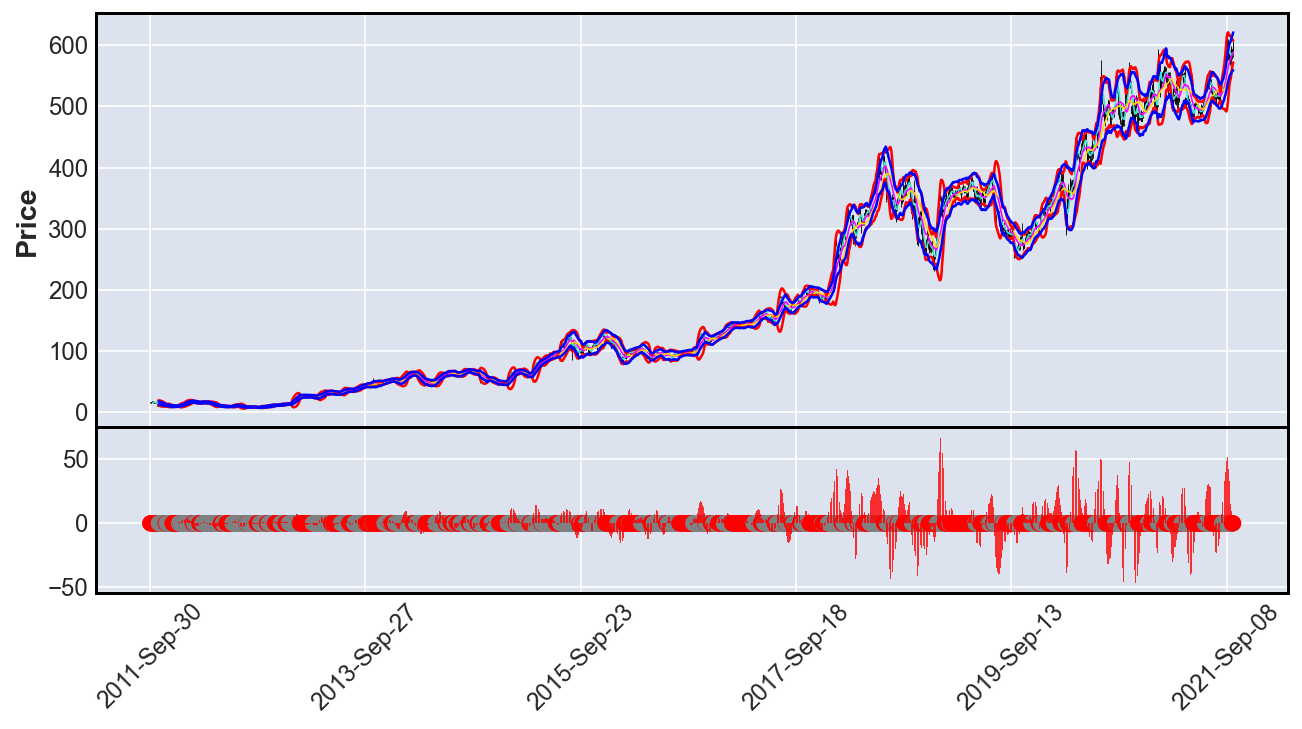

In [176]:
import panel as pn
from panel.interact import interact

pn.extension()

def figure_stock_d(stock):
    apds = [mpf.make_addplot(ticker_dict_1d[stock]['value'], panel=1, type='bar', color=colors_d, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(ticker_dict_1d[stock]), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in ticker_dict_1d[stock]['squeeze_off']], secondary_y=False),
            mpf.make_addplot(ticker_dict_1d[stock][['upper_BB']], color = 'red'),
            mpf.make_addplot(ticker_dict_1d[stock][['lower_BB']], color = 'red'),
            mpf.make_addplot(ticker_dict_1d[stock][['upper_KC']], color = 'blue'),
            mpf.make_addplot(ticker_dict_1d[stock][['lower_KC']], color = 'blue')]

    # plot ohcl with subplots
    fig, axes = mpf.plot(ohcl_d[stock], 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              mav = (8,21,34),
              type='candle', 
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

ticker = daily_data["ticker"].unique()
interact(figure_stock_d, stock=ticker)